In [1]:
import numpy as np, sympy as sp, pandas as pd, sklearn
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.base import (
    BaseEstimator,
    TransformerMixin
)
import dateutil, datetime
import collections, itertools

sns.set_palette('Set1')

%matplotlib inline

In [2]:
X_train, X_test, y_train = pd.read_csv('X_train.csv'), pd.read_csv('X_test.csv'), pd.read_csv('y_train.csv')

Well let's see what we've got:

In [3]:
X_train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [4]:
X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


There's a lot of categorical variables in there.
We'll need to know which levels will be useful for the actual test data:

In [5]:
def show_intersections(A, B, add_cat_feats=['date_recorded', 'construction_year',
                                            'date_recorded_year', 'date_recorded_month']):
    cat_features = np.where(np.array([(X_train[c].dtype == object)
                                  or (c.endswith('code'))
                                  or (c in add_cat_feats) for c in X_train.columns.values]))[0]
    cat_feats_observed = []
    for c in cat_features:
        n_uni = len(set(A.iloc[:,c]).union(B.iloc[:,c]))
        n_int = len(set(A.iloc[:,c]).intersection(B.iloc[:,c]))
        n_te = len(set(A.iloc[:,c]))
        cat_feats_observed.append((A.columns[c], n_int/n_uni, n_int/n_te))
    cat_feats_observed = (
        pd.DataFrame(cat_feats_observed, columns=['var', 'intersection/union', 'intersection/B'])
        .sort_values('intersection/B')
    )
    return cat_feats_observed
show_intersections(X_train, X_test)

,var,intersection/union,intersection/B
3,wpt_name,0.055950,0.068342
5,subvillage,0.294315,0.326939
2,installer,0.343011,0.385368
1,funder,0.344699,0.388830
14,scheme_name,0.563960,0.599926
0,date_recorded,0.861789,0.893258
13,scheme_management,0.923077,0.923077
10,ward,0.930887,0.933556
17,extraction_type,0.944444,0.944444
7,region_code,0.962963,0.962963


In [6]:
for c in X_train.columns:
    display(c, pd.DataFrame(X_train[c].value_counts().head(4)))

'id'

,id
2047,1
72310,1
49805,1
51852,1


'amount_tsh'

,amount_tsh
0.0,41639
500.0,3102
50.0,2472
1000.0,1488


'date_recorded'

,date_recorded
2011-03-15,572
2011-03-17,558
2013-02-03,546
2011-03-14,520


'funder'

,funder
Government Of Tanzania,9084
Danida,3114
Hesawa,2202
Rwssp,1374


'gps_height'

,gps_height
0,20438
-15,60
-16,55
-13,55


'installer'

,installer
DWE,17402
Government,1825
RWE,1206
Commu,1060


'longitude'

,longitude
0.000000,1812
37.540901,2
33.010510,2
39.093484,2


'latitude'

,latitude
-2.000000e-08,1812
-6.985842e+00,2
-3.797579e+00,2
-6.981884e+00,2


'wpt_name'

,wpt_name
none,3563
Shuleni,1748
Zahanati,830
Msikitini,535


'num_private'

,num_private
0,58643
6,81
1,73
5,46


'basin'

,basin
Lake Victoria,10248
Pangani,8940
Rufiji,7976
Internal,7785


'subvillage'

,subvillage
Madukani,508
Shuleni,506
Majengo,502
Kati,373


'region'

,region
Iringa,5294
Shinyanga,4982
Mbeya,4639
Kilimanjaro,4379


'region_code'

,region_code
11,5300
17,5011
12,4639
3,4379


'district_code'

,district_code
1,12203
2,11173
3,9998
4,8999


'lga'

,lga
Njombe,2503
Arusha Rural,1252
Moshi Rural,1251
Bariadi,1177


'ward'

,ward
Igosi,307
Imalinyi,252
Siha Kati,232
Mdandu,231


'population'

,population
0,21381
1,7025
200,1940
150,1892


'public_meeting'

,public_meeting
True,51011
False,5055


'recorded_by'

,recorded_by
GeoData Consultants Ltd,59400


'scheme_management'

,scheme_management
VWC,36793
WUG,5206
Water authority,3153
WUA,2883


'scheme_name'

,scheme_name
K,682
None,644
Borehole,546
Chalinze wate,405


'permit'

,permit
True,38852
False,17492


'construction_year'

,construction_year
0,20709
2010,2645
2008,2613
2009,2533


'extraction_type'

,extraction_type
gravity,26780
nira/tanira,8154
other,6430
submersible,4764


'extraction_type_group'

,extraction_type_group
gravity,26780
nira/tanira,8154
other,6430
submersible,6179


'extraction_type_class'

,extraction_type_class
gravity,26780
handpump,16456
other,6430
submersible,6179


'management'

,management
vwc,40507
wug,6515
water board,2933
wua,2535


'management_group'

,management_group
user-group,52490
commercial,3638
parastatal,1768
other,943


'payment'

,payment
never pay,25348
pay per bucket,8985
pay monthly,8300
unknown,8157


'payment_type'

,payment_type
never pay,25348
per bucket,8985
monthly,8300
unknown,8157


'water_quality'

,water_quality
soft,50818
salty,4856
unknown,1876
milky,804


'quality_group'

,quality_group
good,50818
salty,5195
unknown,1876
milky,804


'quantity'

,quantity
enough,33186
insufficient,15129
dry,6246
seasonal,4050


'quantity_group'

,quantity_group
enough,33186
insufficient,15129
dry,6246
seasonal,4050


'source'

,source
spring,17021
shallow well,16824
machine dbh,11075
river,9612


'source_type'

,source_type
spring,17021
shallow well,16824
borehole,11949
river/lake,10377


'source_class'

,source_class
groundwater,45794
surface,13328
unknown,278


'waterpoint_type'

,waterpoint_type
communal standpipe,28522
hand pump,17488
other,6380
communal standpipe multiple,6103


'waterpoint_type_group'

,waterpoint_type_group
communal standpipe,34625
hand pump,17488
other,6380
improved spring,784


#### [NA] Detecting spoiled data

Looks like all these zeros and `unknown`'s were put into dataset like placeholders
while the true values are simply missing.
We'll replace these dummies with `NA`'s and handle them later

In [7]:
X_train.drop(['num_private', 'recorded_by'], axis=1, inplace=True)
X_test.drop(['num_private', 'recorded_by'], axis=1, inplace=True)
X_train.replace([-np.inf, np.inf, 0, '', 'unknown', 'other', 'others'], np.nan, inplace=True)
X_train.ix[0,'id'] = 0
X_test.replace([-np.inf, np.inf, 0, '', 'unknown', 'other', 'others'], np.nan, inplace=True)

X_train.loc[X_train['population'] == 1, 'population'] = np.nan
X_test.loc[X_test['population'] == 1, 'population'] = np.nan

/home/god/scipy/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


#### [Feature Extraction] Parsing `date_recorded`
The date the record was made together with `construction_year` yields supposed `age` of the waterpoint

In [8]:
class SplitDate(BaseEstimator, TransformerMixin):
    def __init__(self, col='date_recorded', drop=True):
        self.col = col
        self.drop = drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def t(x):
            if isinstance(x, str):
                x = dateutil.parser.parse(x)
            return (x.year, x.month, x.day, x.weekday())
        X = X.copy()
        (X.loc[:, self.col + '_year'],
         X.loc[:, self.col + '_month'],
         X.loc[:, self.col + '_day'],
         X.loc[:, self.col + '_weekday']) = zip(
        *X.loc[:, self.col].map(t))
        if self.drop:
            X = X.drop(self.col, axis=1)
        return X


X_train = SplitDate().fit_transform(X_train)
X_test = SplitDate().fit_transform(X_test)

#### [Feature Extraction] `has_name`

Clearly levels of `wpt_name` won't tell us much about `X_test`.
But it could be that there is a difference between named and unnamed waterpoints.

Although in the future we'll try to apply `CountVectorizer` to all of the factors
including `wpt_name` and filter them using some stat test.

In [9]:
X_train.loc[:,'wpt_name'] = X_train['wpt_name'].notnull() * 1
X_test.loc[:,'wpt_name'] = X_test['wpt_name'].notnull() * 1

### Visualization

In [10]:
X_train_labeled = pd.merge(X_train, y_train, on='id')
X_plt = X_train_labeled.drop(['id', 'wpt_name', 'num_private'], axis=1, errors='ignore')

In [11]:
X_plt.notnull().all(axis=1).sum()

7528

#### [NA]
Now let's display **missing data**

In [12]:
def is_missing(x):
    return pd.isnull(x) # or (x in [-np.inf, np.inf, 0] and x is not False)

def get_na(X):
    na = X.applymap(is_missing).sum()
    na = na[na > 0 ]
    return na.sort_values() # pd.DataFrame(na.sort_values())

In [13]:
display(pd.concat((get_na(X_train), get_na(X_test), ), axis=1)
        .drop('id').sort_values(0).add_prefix('n_missing_'),
        X_train.isnull().sum().sum(),
        X_test.isnull().sum().sum())

,n_missing_0,n_missing_1
district_code,23,4.0
source_class,278,69.0
source_type,278,69.0
source,278,69.0
subvillage,371,99.0
quantity_group,789,186.0
quantity,789,186.0
management,1405,361.0
management_group,1504,388.0
longitude,1812,457.0


241215

60712

Then display a huge **pairplot** of joint distributions:


/home/god/scipy/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/god/scipy/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


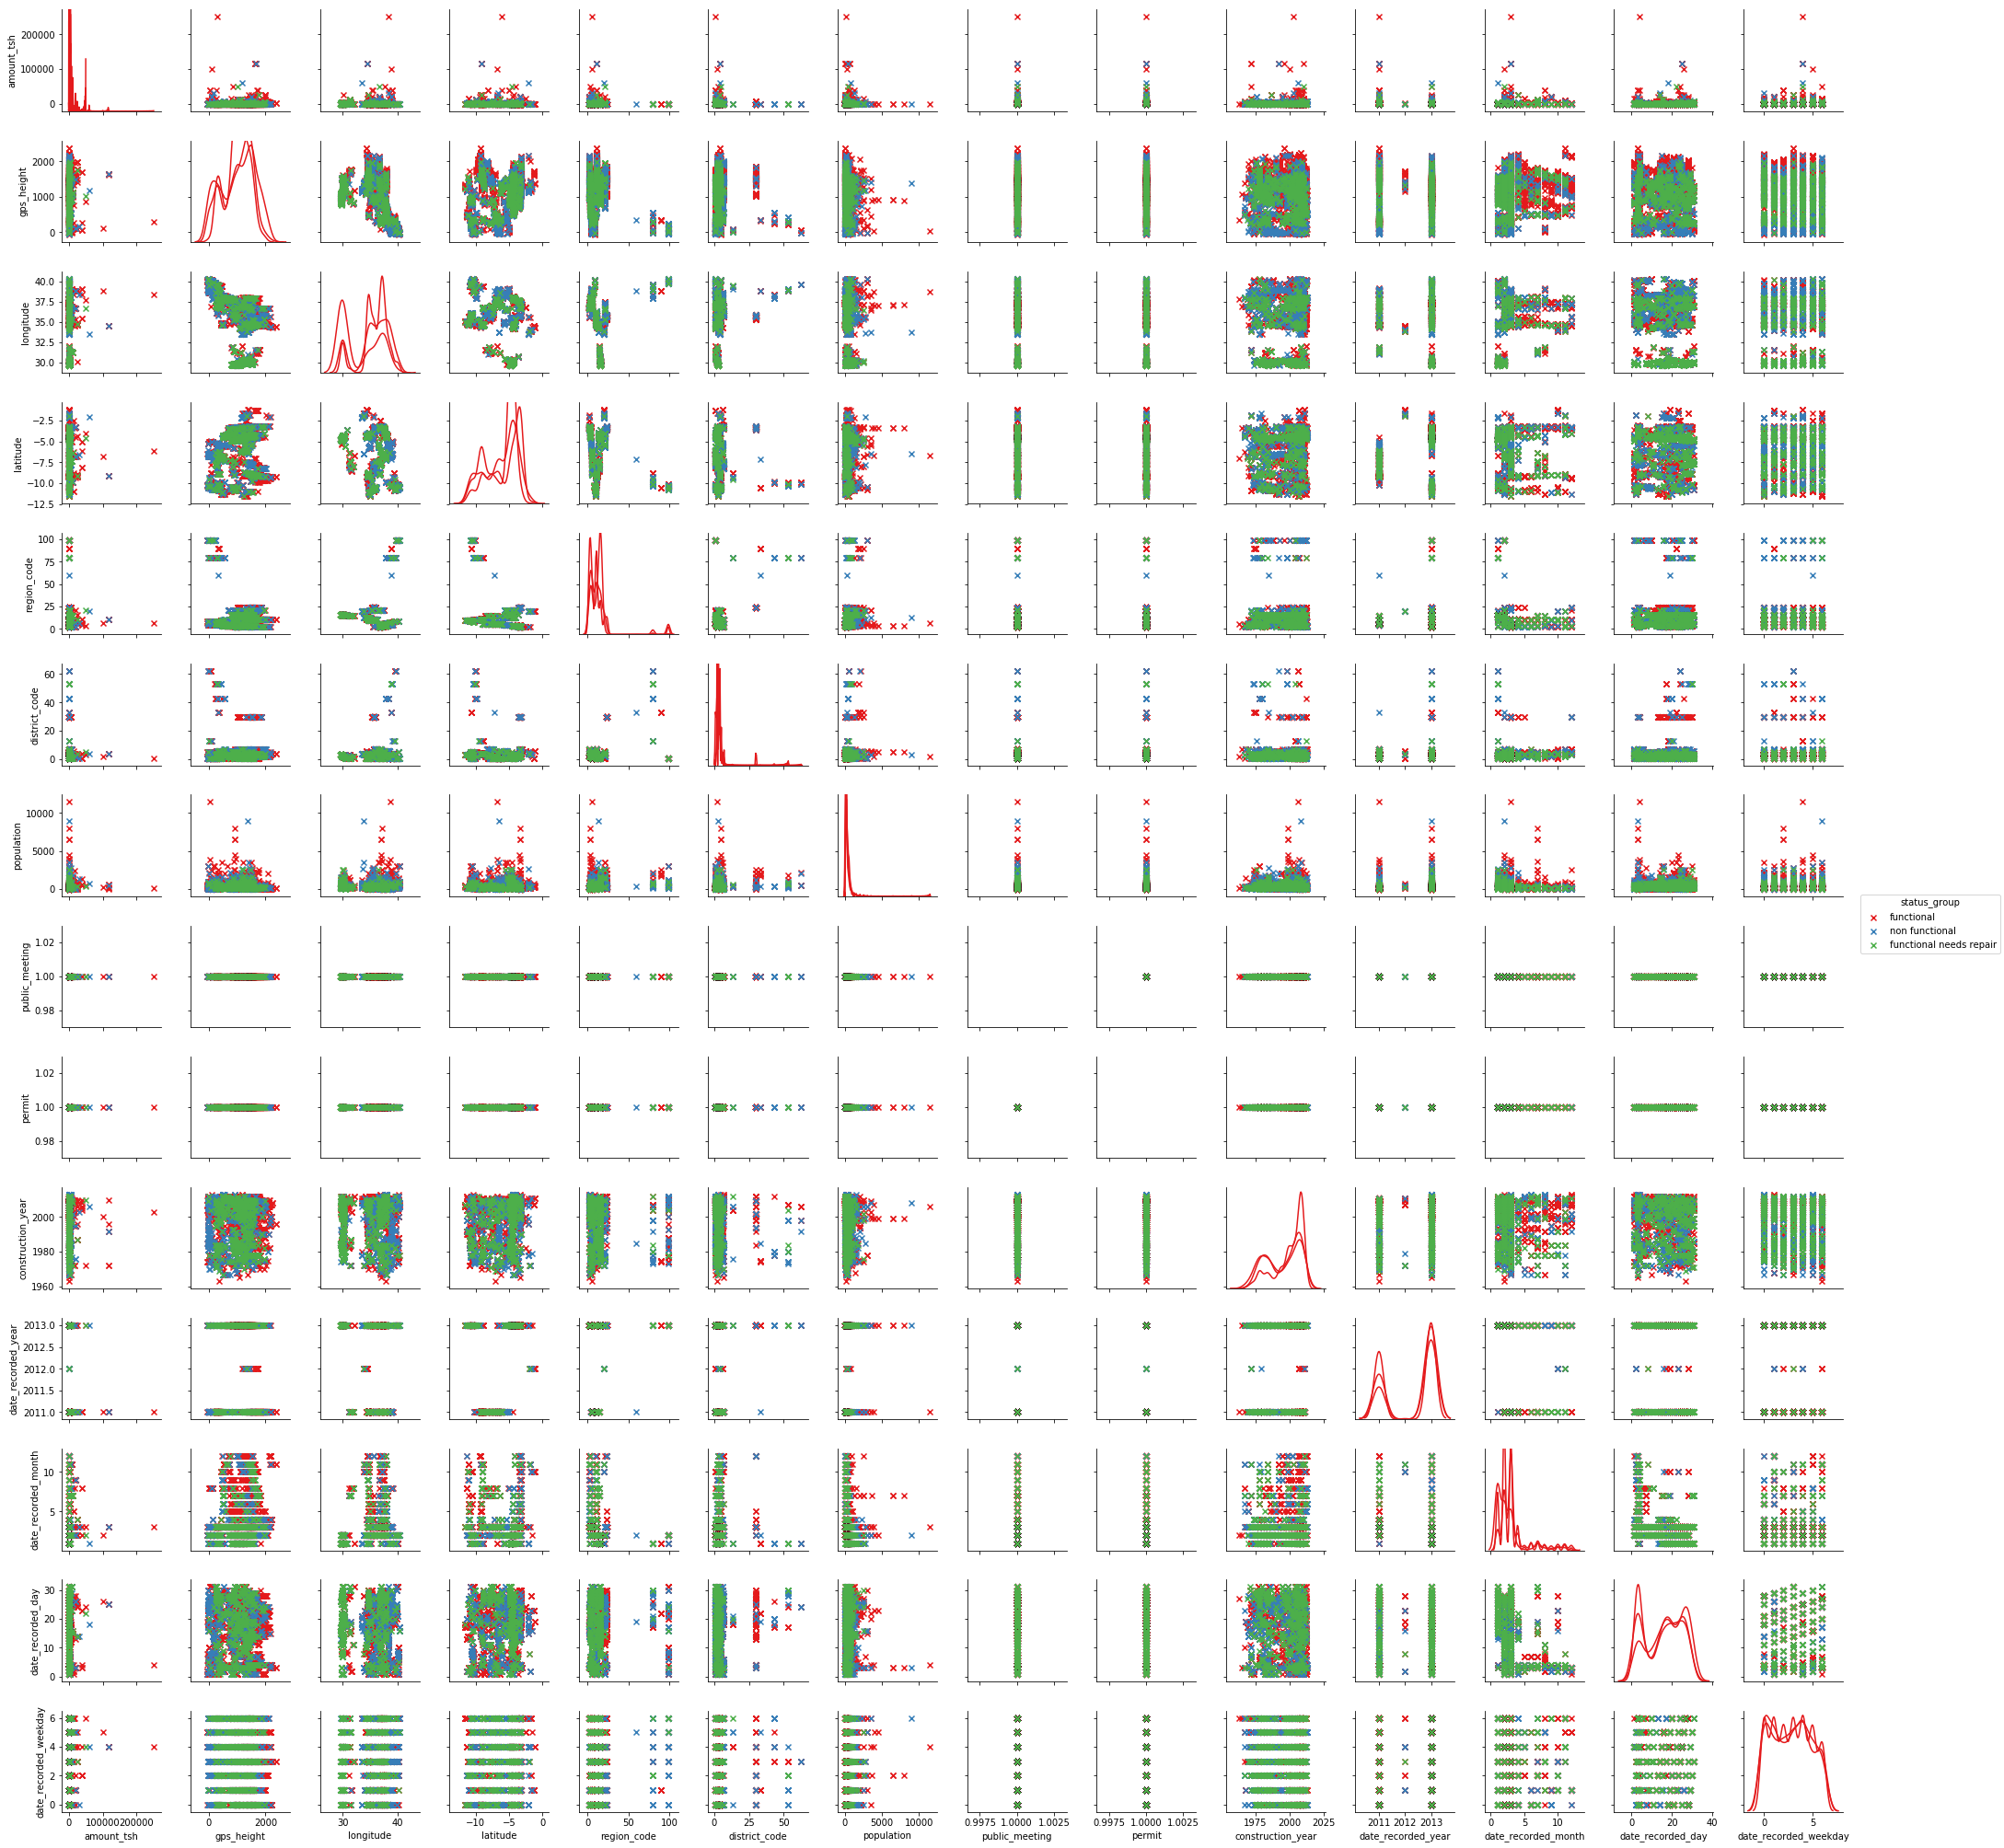

In [14]:
sns.pairplot(X_plt.loc[X_plt.notnull().all(axis=1), :],
             hue='status_group',
             markers='x',
             diag_kind='kde',
             size=2)

#### [Visualization] Descriptive statistics

In [15]:
X_train.drop('id', axis=1).describe()

,amount_tsh,gps_height,longitude,latitude,wpt_name,region_code,district_code,population,construction_year,date_recorded_year,date_recorded_month,date_recorded_day,date_recorded_weekday
count,17761.000000,38962.000000,57588.000000,5.940000e+04,59400.0,59400.000000,59377.000000,30994.000000,38691.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,1062.351942,1018.860839,35.149669,-5.706033e+00,1.0,15.297003,5.631928,344.570820,1996.814686,2011.921667,4.375640,15.621498,2.939933
std,5409.344940,612.566092,2.607428,2.946019e+00,0.0,17.587406,9.634877,607.731177,12.472045,0.958758,3.029247,8.687553,1.951627
min,0.200000,-90.000000,29.607122,-1.164944e+01,1.0,1.000000,1.000000,2.000000,1960.000000,2002.000000,1.000000,1.000000,0.000000
25%,50.000000,393.000000,33.285100,-8.540621e+00,1.0,5.000000,2.000000,100.000000,1987.000000,2011.000000,2.000000,8.000000,1.000000
50%,250.000000,1167.000000,35.005943,-5.021597e+00,1.0,12.000000,3.000000,200.000000,2000.000000,2012.000000,3.000000,16.000000,3.000000
75%,1000.000000,1498.000000,37.233712,-3.326156e+00,1.0,17.000000,5.000000,380.000000,2008.000000,2013.000000,7.000000,23.000000,5.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1.0,99.000000,80.000000,30500.000000,2013.000000,2013.000000,12.000000,31.000000,6.000000


#### Levels and unique values

See the **number of levels** for each variable

In [16]:
pd.DataFrame(X_train.agg(lambda x: x.unique().size).sort_values(), columns=['cnt'])

,cnt
wpt_name,1
permit,2
public_meeting,2
source_class,3
management_group,4
quantity_group,5
date_recorded_year,5
quantity,5
quality_group,6
payment,6


In [17]:
X_train.drop(['longitude', 'latitude'], axis=1, inplace=True, errors='ignore')
X_test.drop(['longitude', 'latitude'], axis=1, inplace=True, errors='ignore')

In [18]:
pd.DataFrame(X_train.groupby(['extraction_type_class', 'extraction_type_group'])['extraction_type'].value_counts())

extraction_type
extraction_type_class extraction_type_group extraction_type                           
gravity               gravity               gravity                              26780
handpump              afridev               afridev                               1770
                      india mark ii         india mark ii                         2400
                      india mark iii        india mark iii                          98
                      nira/tanira           nira/tanira                           8154
                      other handpump        other - swn 81                         229
                                            other - play pump                       85
                                            walimi                                  48
                                            other - mkulima/shinyanga                2
                      swn 80                swn 80                                3670
motorpump             mono                  mono                                  2865
                      other motorpump       cemo                                    90
                                            climax                                  32
rope pump             rope pump             other - rope pump                      451
submersible           submersible           submersible                           4764
                                            ksb                                   1415
wind-powered          wind-powered          windmill                               117

In [19]:
pd.DataFrame(X_train.groupby(['source_class', 'source_type'])['source'].value_counts())

source
source_class source_type          source                      
groundwater  borehole             machine dbh            11075
                                  hand dtw                 874
             shallow well         shallow well           16824
             spring               spring                 17021
surface      dam                  dam                      656
             rainwater harvesting rainwater harvesting    2295
             river/lake           river                   9612
                                  lake                     765

In [20]:
X_train.scheme_name.value_counts()

K                                        682
None                                     644
Borehole                                 546
Chalinze wate                            405
M                                        400
DANIDA                                   379
Government                               320
Ngana water supplied scheme              270
wanging'ombe water supply s              261
wanging'ombe supply scheme               234
I                                        229
Bagamoyo wate                            229
Uroki-Bomang'ombe water sup              209
N                                        204
Kirua kahe gravity water supply trust    193
Machumba estate pipe line                185
Makwale water supplied sche              166
Kijiji                                   161
S                                        154
Losaa-Kia water supply                   152
Handeni Trunk Main(H                     152
mtwango water supply scheme              152
Mkongoro T

In [21]:
'Imalinyi' in X_train.subvillage

False

In [22]:
X_labeled = pd.merge(X_train, y_train, on='id')

In [23]:
def cat_outcomes_proprtions(cat):
    cat_cnts = X_labeled[cat].value_counts()
    return (X_labeled
     .groupby([cat])['status_group']
     .value_counts()
     .unstack()
     .transform(lambda x: x/cat_cnts)
    )


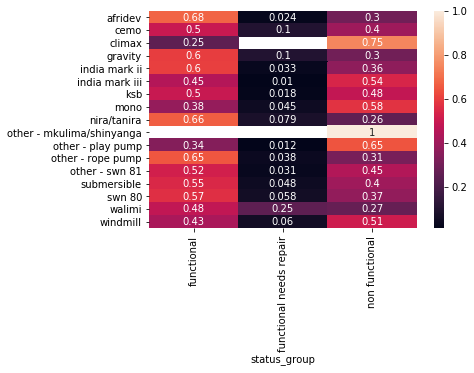

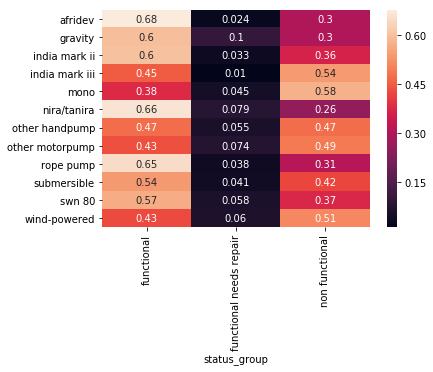

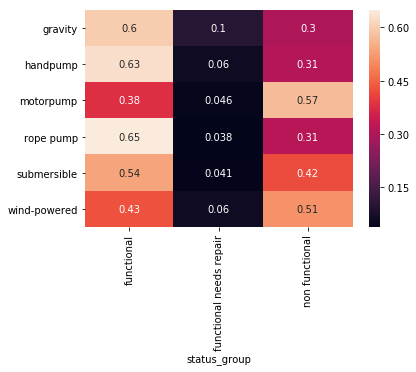

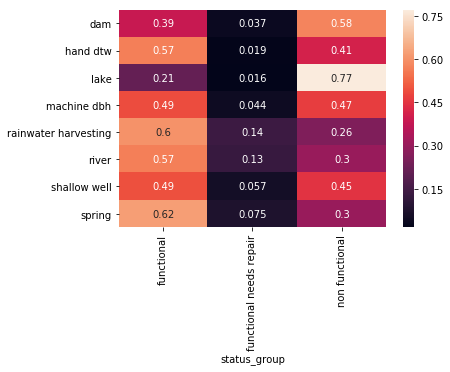

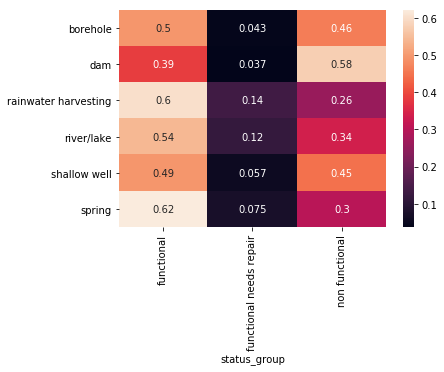

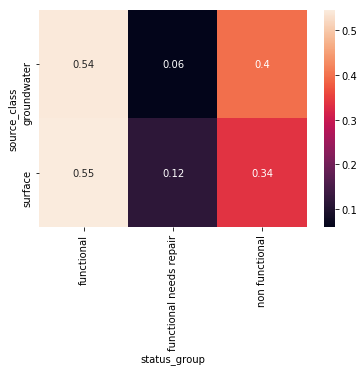

In [24]:
sns.heatmap(cat_outcomes_proprtions('extraction_type'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('extraction_type_group'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('extraction_type_class'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('source'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('source_type'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('source_class'), annot=True)
plt.show()

In [25]:
full = pd.concat((X_train, X_test,), axis=0)

In [26]:
X_train.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'date_recorded_year', 'date_recorded_month', 'date_recorded_day',
       'date_recorded_weekday'],
      dtype='object')

# Missing data

Now let's display the **missing data**

In [27]:
def is_missing(x):
    return pd.isnull(x) # or (x in [-np.inf, np.inf, 0] and x is not False)

def get_na(X):
    na = X.applymap(is_missing).sum()
    na = na[na > 0 ]
    return na.sort_values() # pd.DataFrame(na.sort_values())

In [28]:
display(pd.concat((get_na(X_train), get_na(X_test), ), axis=1).drop('id').sort_values(0),
        X_train.isnull().sum().sum(),
        X_test.isnull().sum().sum())

,0,1
district_code,23,4.0
source_class,278,69.0
source_type,278,69.0
source,278,69.0
subvillage,371,99.0
quantity_group,789,186.0
quantity,789,186.0
management,1405,361.0
management_group,1504,388.0
water_quality,1876,469.0


239403

60255

First we'll convert booleans to floats of $0, 0.5$ and $1$
which stand for `False`, `nan` and `True` respectively

In [29]:
def prep_bool(col):
    X_train.loc[X_train.loc[:,col] == True, col] = 1
    X_train.loc[X_train.loc[:,col] == False, col] = 0
    X_train.loc[:,col].fillna(0.5, inplace=True)
prep_bool('permit')
prep_bool('public_meeting')

In [30]:
cat_feats = np.array(['funder', 'installer', 'basin', 'subvillage',
                      'region', 'region_code', 'district_code', 'lga', 'ward',
                      'scheme_management', 'scheme_name',
                      'extraction_type', 'extraction_type_group', 'extraction_type_class',
                      'management', 'management_group', 'payment', 'payment_type',
                      'water_quality', 'quality_group', 'quantity', 'quantity_group',
                      'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'])
num_feats = np.array(['amount_tsh', 'population', 'gps_height', 'permit', 'public_meeting'])

In [32]:
def remember_na(col):
    X_train[col + '_known'] = 1*X_train[col].notnull()
    X_test[col + '_known'] = 1*X_test[col].notnull()

for c in [_ for _ in X_train.columns]:
    remember_na(c)

In [33]:
def first(x):
    return x[0] if len(x) > 0 else np.nan

def nummed_catmode(x):
    return x.median() if np.issubdtype(x.dtype, np.number) else first(x.value_counts().index)

def fill_w_nummed_catmode(x):
    return x.fillna(nummed_catmode(x))

def fill_df_w_nummed_catmode(df):
    return df.fillna(df.apply(fill_w_nummed_catmode))
        
def groupby_fill_cols(by, cols):
    global X_train, X_test
    X_tr_by = X_train.groupby(by)
    X_te_by = X_test.groupby(by)
    
    if X_train.isnull().any().any():
        tr_med = X_tr_by.apply(fill_df_w_nummed_catmode).loc[:,cols]
        #tr_med = fill_df_w_nummed_catmode(tr_med)
        X_train.loc[:,cols] = X_train.loc[:,cols].fillna(tr_med)
    if X_test.isnull().any().any():
        te_med = X_te_by.apply(fill_df_w_nummed_catmode).loc[:,cols]
        #te_med = fill_df_w_nummed_catmode(te_med)
        X_test.loc[:,cols] = X_test.loc[:,cols].fillna(te_med)
    
def groupby_fill(by):
    global X_train, X_test
    X_tr_by = X_train.groupby(by)
    X_te_by = X_test.groupby(by)
    
    if X_train.isnull().any().any():
        tr_med = X_tr_by.apply(fill_df_w_nummed_catmode)
        #tr_med = fill_df_w_nummed_catmode(tr_med)
        X_train = X_train.fillna(tr_med)
    if X_test.isnull().any().any():
        te_med = X_te_by.apply(fill_df_w_nummed_catmode)
        #te_med = fill_df_w_nummed_catmode(te_med)
        X_test = X_test.fillna(te_med)
    print('%s nulls' % (X_train.isnull().sum().sum() + X_test.isnull().sum().sum()))

def fill_col_const(colconsts):
    for col, const in colconsts:
        X_train.loc[X_train[col].isnull(), col] = const
        X_test.loc[X_test[col].isnull(), col] = const

# 

tr_unk_ward = X_train['ward'].isnull()
te_unk_ward = X_test['ward'].isnull()
X_train.loc[tr_unk_ward, cat_feats] = X_train.loc[tr_unk_ward, cat_feats].fillna('unknown')
X_test.loc[te_unk_ward, cat_feats] = X_test.loc[te_unk_ward, cat_feats].fillna('unknown')

print('%s nulls' % (X_train.isnull().sum().sum() + X_test.isnull().sum().sum()))
groupby_fill_cols(['lga', 'source_class'], 'source')
groupby_fill_cols(['lga', 'extraction_type_class'], 'extraction_type')
groupby_fill(['basin', 'region', 'lga', 'ward'])
groupby_fill(['basin', 'region', 'lga'])
groupby_fill(['basin', 'region'])
print('%s nulls' % (X_train.isnull().sum().sum() + X_test.isnull().sum().sum()))
groupby_fill_cols('ward', ['basin', 'ward', 'lga', 'region'])
X_train.loc[:, cat_feats] = X_train.loc[:, cat_feats].fillna('unknown')
X_test.loc[:, cat_feats] = X_test.loc[:, cat_feats].fillna('unknown')
groupby_fill('basin')
#groupby_fill('region_code')
#groupby_fill('district_code')

270721 nulls
158025 nulls
109779 nulls
77979 nulls
77979 nulls
0 nulls


In [34]:
display(pd.concat((get_na(X_train), get_na(X_test), ), axis=1).drop('id', errors='ignore').sort_values(0),)

,0,1


In [35]:
X_train.loc[:,'age'] = X_train.loc[:,'date_recorded_year'] - X_train.loc[:,'construction_year']
X_test.loc[:,'age'] = X_test.loc[:,'date_recorded_year'] - X_test.loc[:,'construction_year']

## Preparing training and validation sets

In [36]:
y_train['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'], dtype=object)

In [37]:
y_levels = ['non functional', 'functional needs repair', 'functional']

y_train.loc[:, 'status_group'] = y_train.loc[:, 'status_group'].map(lambda x: {
    'functional': 2,
    'functional needs repair': 1,
    'non functional': 0
}[x])

In [38]:
def split_train_cv_test(X, y, proportions=(.75, .25/2, .25/2)):
    # expecting $y$ to be numpy array
    outs = np.unique(y)
    proportions = np.array(proportions)
    classes = [np.where(y == i)[0] for i in outs]
    xparts = [[] for _ in proportions]
    yparts = [[] for _ in proportions]
    for cidx in classes:
        cidx = sklearn.utils.shuffle(cidx)
        cprops = cidx.size * proportions
        cprops = cprops.astype(int)
        cprops[-1] = cidx.size - cprops[:-1].sum()
        # print(cidx)
        cx = X.iloc[cidx,:]
        cy = y[cidx]
        for xpart, ypart, sz in zip(xparts, yparts, cprops):
            xpart.append(cx.iloc[:sz,:])
            ypart.append(cy[:sz])
            cx, cy = cx.iloc[sz:,:], cy[sz:]
    xparts = [pd.concat(xpart) for xpart in xparts]
    yparts = [np.concatenate(ypart) for ypart in yparts]
    parts = xparts + yparts
    return parts

xtr = X_train.drop(['subvillage', 'amount_tsh',
                    'id', 'date_recorded_day', 'date_recorded_week_day',
                    'date_recorded_year', 'construction_year',
                    'source_class'], axis=1, errors='ignore')

xte = X_test # ref
ytr = y_train.iloc[:,1]
xtr, xcv, xva, ytr, ycv, yva = (
    split_train_cv_test(xtr, ytr, proportions=(.7, .15, .15))
)

## CatboostClassifier

Let's check out what we can we get on the raw data

In [39]:
import catboost

In [40]:
cbclf = catboost.CatBoostClassifier(500, loss_function='MultiClass',
                                    eval_metric='Accuracy',
                                    auto_stop_pval=5e-10,
                                    verbose=True,
                                    calc_feature_importance=True)

In [41]:
cbclf.fit(xtr.values,
          ytr,
          eval_set=(xcv, ycv),
          cat_features=[xtr.columns.get_loc(c) for c in cat_feats if c in xtr.columns], verbose=True)
display(cbclf.score(xtr, ytr),
        cbclf.score(xcv, ycv),
        cbclf.score(xva, yva),
        pd.DataFrame(cbclf.feature_importance_, index=xtr.columns.values).sort_values(0)
)

Borders generated
0:	learn 0.7432536438	test 0.7498877414	bestTest 0.7498877414		total: 935ms	remaining: 7m 46s
1:	learn 0.745682813	test 0.7565110013	bestTest 0.7565110013		total: 1.63s	remaining: 6m 45s
2:	learn 0.747005628	test 0.7568477773	bestTest 0.7568477773		total: 2.2s	remaining: 6m 5s
3:	learn 0.7459714272	test 0.7567355186	bestTest 0.7568477773		total: 2.79s	remaining: 5m 45s
4:	learn 0.7480398288	test 0.7583071396	bestTest 0.7583071396		total: 3.34s	remaining: 5m 30s
5:	learn 0.7471258839	test 0.75662326	bestTest 0.7583071396		total: 3.92s	remaining: 5m 23s
6:	learn 0.7478955217	test 0.75662326	bestTest 0.7583071396		total: 4.65s	remaining: 5m 27s
7:	learn 0.7507816634	test 0.7621239335	bestTest 0.7621239335		total: 5.21s	remaining: 5m 20s
8:	learn 0.7514069941	test 0.76324652	bestTest 0.76324652		total: 5.77s	remaining: 5m 14s
9:	learn 0.7519842224	test 0.7625729681	bestTest 0.76324652		total: 6.37s	remaining: 5m 12s
10:	learn 0.7517677618	test 0.7650426583	bestTest 0.7650

87:	learn 0.7730049545	test 0.7840143691	bestTest 0.7840143691		total: 46.7s	remaining: 3m 38s
88:	learn 0.7730049545	test 0.7842388864	bestTest 0.7842388864		total: 47.3s	remaining: 3m 38s
89:	learn 0.7731733128	test 0.7844634037	bestTest 0.7844634037		total: 47.7s	remaining: 3m 37s
90:	learn 0.7733897734	test 0.7841266278	bestTest 0.7844634037		total: 48.2s	remaining: 3m 36s
91:	learn 0.7737505412	test 0.7848001796	bestTest 0.7848001796		total: 48.8s	remaining: 3m 36s
92:	learn 0.7737505412	test 0.7848001796	bestTest 0.7848001796		total: 49.3s	remaining: 3m 35s
93:	learn 0.7737024388	test 0.7848001796	bestTest 0.7848001796		total: 49.8s	remaining: 3m 35s
94:	learn 0.7738226947	test 0.7850246969	bestTest 0.7850246969		total: 50.3s	remaining: 3m 34s
95:	learn 0.7738467459	test 0.7851369555	bestTest 0.7851369555		total: 50.8s	remaining: 3m 33s
96:	learn 0.7740391553	test 0.7852492142	bestTest 0.7852492142		total: 51.3s	remaining: 3m 33s
97:	learn 0.7741113089	test 0.7855859901	bestTest 

173:	learn 0.7814709702	test 0.7904131118	bestTest 0.7908621464		total: 1m 31s	remaining: 2m 50s
174:	learn 0.7815671749	test 0.7904131118	bestTest 0.7908621464		total: 1m 31s	remaining: 2m 50s
175:	learn 0.7816633797	test 0.7906376291	bestTest 0.7908621464		total: 1m 32s	remaining: 2m 49s
176:	learn 0.7816152773	test 0.7904131118	bestTest 0.7908621464		total: 1m 32s	remaining: 2m 49s
177:	learn 0.7817595844	test 0.7903008532	bestTest 0.7908621464		total: 1m 33s	remaining: 2m 48s
178:	learn 0.7818557891	test 0.7903008532	bestTest 0.7908621464		total: 1m 33s	remaining: 2m 48s
179:	learn 0.7819279427	test 0.7904131118	bestTest 0.7908621464		total: 1m 34s	remaining: 2m 47s
180:	learn 0.7819519938	test 0.7905253705	bestTest 0.7908621464		total: 1m 34s	remaining: 2m 47s
181:	learn 0.7821925057	test 0.7905253705	bestTest 0.7908621464		total: 1m 35s	remaining: 2m 46s
182:	learn 0.7822646592	test 0.7904131118	bestTest 0.7908621464		total: 1m 36s	remaining: 2m 46s
183:	learn 0.7824570686	test 0

259:	learn 0.7854634663	test 0.7924337674	bestTest 0.7924337674		total: 2m 16s	remaining: 2m 5s
260:	learn 0.7852710568	test 0.792546026	bestTest 0.792546026		total: 2m 16s	remaining: 2m 5s
261:	learn 0.7853191592	test 0.792546026	bestTest 0.792546026		total: 2m 17s	remaining: 2m 4s
262:	learn 0.7853913127	test 0.7927705433	bestTest 0.7927705433		total: 2m 17s	remaining: 2m 4s
263:	learn 0.7853913127	test 0.792546026	bestTest 0.7927705433		total: 2m 18s	remaining: 2m 3s
264:	learn 0.785559671	test 0.792882802	bestTest 0.792882802		total: 2m 18s	remaining: 2m 3s
265:	learn 0.7855837222	test 0.7927705433	bestTest 0.792882802		total: 2m 19s	remaining: 2m 2s
266:	learn 0.7855356198	test 0.792546026	bestTest 0.792882802		total: 2m 19s	remaining: 2m 2s
267:	learn 0.7856558757	test 0.792546026	bestTest 0.792882802		total: 2m 20s	remaining: 2m 1s
268:	learn 0.7856799269	test 0.7926582847	bestTest 0.792882802		total: 2m 20s	remaining: 2m 1s
269:	learn 0.7854875174	test 0.792546026	bestTest 0.79

345:	learn 0.7873154072	test 0.7943421643	bestTest 0.7951279749		total: 3m	remaining: 1m 20s
346:	learn 0.787291356	test 0.7943421643	bestTest 0.7951279749		total: 3m 1s	remaining: 1m 19s
347:	learn 0.7873635095	test 0.7943421643	bestTest 0.7951279749		total: 3m 1s	remaining: 1m 19s
348:	learn 0.7874837655	test 0.7946789403	bestTest 0.7951279749		total: 3m 2s	remaining: 1m 18s
349:	learn 0.7875078166	test 0.7947911989	bestTest 0.7951279749		total: 3m 2s	remaining: 1m 18s
350:	learn 0.787555919	test 0.7949034576	bestTest 0.7951279749		total: 3m 3s	remaining: 1m 17s
351:	learn 0.7876040214	test 0.7949034576	bestTest 0.7951279749		total: 3m 3s	remaining: 1m 17s
352:	learn 0.7875799702	test 0.7951279749	bestTest 0.7951279749		total: 3m 4s	remaining: 1m 16s
353:	learn 0.7876521237	test 0.7950157162	bestTest 0.7951279749		total: 3m 4s	remaining: 1m 16s
354:	learn 0.7876761749	test 0.7949034576	bestTest 0.7951279749		total: 3m 5s	remaining: 1m 15s
355:	learn 0.7876040214	test 0.7947911989	bes

431:	learn 0.7898648324	test 0.7961383026	bestTest 0.797934441		total: 3m 45s	remaining: 35.5s
432:	learn 0.790081293	test 0.796026044	bestTest 0.797934441		total: 3m 46s	remaining: 35s
433:	learn 0.7900572418	test 0.7959137854	bestTest 0.797934441		total: 3m 46s	remaining: 34.5s
434:	learn 0.7901293954	test 0.796026044	bestTest 0.797934441		total: 3m 47s	remaining: 34s
435:	learn 0.7901534465	test 0.796026044	bestTest 0.797934441		total: 3m 47s	remaining: 33.5s
436:	learn 0.7901293954	test 0.7961383026	bestTest 0.797934441		total: 3m 48s	remaining: 32.9s
437:	learn 0.7900572418	test 0.7961383026	bestTest 0.797934441		total: 3m 48s	remaining: 32.4s
438:	learn 0.790081293	test 0.7961383026	bestTest 0.797934441		total: 3m 49s	remaining: 31.9s
439:	learn 0.7900572418	test 0.7962505613	bestTest 0.797934441		total: 3m 50s	remaining: 31.4s
440:	learn 0.7901774977	test 0.7962505613	bestTest 0.797934441		total: 3m 50s	remaining: 30.8s
441:	learn 0.7901534465	test 0.7962505613	bestTest 0.797934

0.85415363894367213

0.7978221823080377

0.8032308727843841

,0
id_known,0.000000
date_recorded_weekday_known,0.000000
wpt_name_known,0.000000
basin_known,0.000000
subvillage_known,0.000000
region_known,0.000000
region_code_known,0.000000
district_code_known,0.000000
ward_known,0.000000
public_meeting_known,0.000000


Huh, looks like we need to discount specifics of regions and organisation

In [42]:
xtr_n_rows = xtr.shape[0]
xtr = pd.concat((xtr.reset_index(drop=True), xtr.reset_index(drop=True)), ignore_index=True)

In [43]:
feats_to_reset = ['lga', 'ward', 'funder', 'installer', 'region', 'region_code', 'district_code']
xtr.loc[xtr_n_rows:, feats_to_reset] = 'unknown'

In [44]:
ytr = np.concatenate((ytr, ytr))

In [45]:
cbclf.fit(xtr.values,
          ytr,
          eval_set=(xcv, ycv),
          cat_features=[xtr.columns.get_loc(c) for c in cat_feats if c in xtr.columns], verbose=True)
display(cbclf.score(xtr, ytr),
        cbclf.score(xcv, ycv),
        cbclf.score(xva, yva)
)

Borders generated
0:	learn 0.7709485786	test 0.7512348451	bestTest 0.7512348451		total: 1.19s	remaining: 9m 53s
1:	learn 0.7743397951	test 0.7611136057	bestTest 0.7611136057		total: 2.17s	remaining: 9m
2:	learn 0.7769012459	test 0.7638078132	bestTest 0.7638078132		total: 3.21s	remaining: 8m 51s
3:	learn 0.7770816297	test 0.7662775034	bestTest 0.7662775034		total: 4.24s	remaining: 8m 45s
4:	learn 0.7784645726	test 0.7654916929	bestTest 0.7662775034		total: 5.23s	remaining: 8m 37s
5:	learn 0.7793063639	test 0.766389762	bestTest 0.766389762		total: 6.15s	remaining: 8m 26s
6:	learn 0.7785728029	test 0.7652671756	bestTest 0.766389762		total: 7.14s	remaining: 8m 23s
7:	learn 0.7780677281	test 0.7650426583	bestTest 0.766389762		total: 8.13s	remaining: 8m 19s
8:	learn 0.7777550628	test 0.7634710373	bestTest 0.766389762		total: 9.13s	remaining: 8m 18s
9:	learn 0.7778031651	test 0.7649303996	bestTest 0.766389762		total: 10.1s	remaining: 8m 14s
10:	learn 0.7793304151	test 0.7653794342	bestTest 0.

87:	learn 0.7924743855	test 0.7772788505	bestTest 0.7772788505		total: 1m 29s	remaining: 6m 56s
88:	learn 0.7925826158	test 0.7770543332	bestTest 0.7772788505		total: 1m 30s	remaining: 6m 56s
89:	learn 0.7926788205	test 0.7773911091	bestTest 0.7773911091		total: 1m 31s	remaining: 6m 54s
90:	learn 0.7927629997	test 0.7773911091	bestTest 0.7773911091		total: 1m 32s	remaining: 6m 54s
91:	learn 0.7929433835	test 0.7773911091	bestTest 0.7773911091		total: 1m 33s	remaining: 6m 53s
92:	learn 0.7932319977	test 0.7773911091	bestTest 0.7773911091		total: 1m 34s	remaining: 6m 52s
93:	learn 0.7932079465	test 0.7776156264	bestTest 0.7776156264		total: 1m 35s	remaining: 6m 52s
94:	learn 0.7934244071	test 0.7778401437	bestTest 0.7778401437		total: 1m 36s	remaining: 6m 51s
95:	learn 0.7933883304	test 0.7778401437	bestTest 0.7778401437		total: 1m 37s	remaining: 6m 50s
96:	learn 0.7935807398	test 0.7786259542	bestTest 0.7786259542		total: 1m 38s	remaining: 6m 49s
97:	learn 0.7934364327	test 0.7785136956

173:	learn 0.8002188657	test 0.7854737315	bestTest 0.7856982488		total: 3m	remaining: 5m 37s
174:	learn 0.8002068402	test 0.7853614728	bestTest 0.7856982488		total: 3m 1s	remaining: 5m 36s
175:	learn 0.8002308913	test 0.7854737315	bestTest 0.7856982488		total: 3m 2s	remaining: 5m 35s
176:	learn 0.8004112752	test 0.7855859901	bestTest 0.7856982488		total: 3m 3s	remaining: 5m 34s
177:	learn 0.8004593776	test 0.7853614728	bestTest 0.7856982488		total: 3m 4s	remaining: 5m 33s
178:	learn 0.8005195055	test 0.7854737315	bestTest 0.7856982488		total: 3m 5s	remaining: 5m 32s
179:	learn 0.800447352	test 0.7855859901	bestTest 0.7856982488		total: 3m 6s	remaining: 5m 31s
180:	learn 0.8006157102	test 0.7859227661	bestTest 0.7859227661		total: 3m 7s	remaining: 5m 30s
181:	learn 0.8006397614	test 0.7860350247	bestTest 0.7860350247		total: 3m 8s	remaining: 5m 29s
182:	learn 0.8007960941	test 0.7859227661	bestTest 0.7860350247		total: 3m 9s	remaining: 5m 28s
183:	learn 0.800856222	test 0.7860350247	bes

259:	learn 0.8050291019	test 0.789402784	bestTest 0.7901885945		total: 4m 31s	remaining: 4m 10s
260:	learn 0.8050411275	test 0.789402784	bestTest 0.7901885945		total: 4m 32s	remaining: 4m 9s
261:	learn 0.805173409	test 0.789402784	bestTest 0.7901885945		total: 4m 33s	remaining: 4m 8s
262:	learn 0.8051854346	test 0.7891782667	bestTest 0.7901885945		total: 4m 34s	remaining: 4m 7s
263:	learn 0.8051253067	test 0.7891782667	bestTest 0.7901885945		total: 4m 35s	remaining: 4m 6s
264:	learn 0.8051854346	test 0.7889537494	bestTest 0.7901885945		total: 4m 36s	remaining: 4m 5s
265:	learn 0.8052816393	test 0.7891782667	bestTest 0.7901885945		total: 4m 37s	remaining: 4m 4s
266:	learn 0.8053177161	test 0.7892905254	bestTest 0.7901885945		total: 4m 38s	remaining: 4m 3s
267:	learn 0.805437972	test 0.7892905254	bestTest 0.7901885945		total: 4m 39s	remaining: 4m 2s
268:	learn 0.8053898696	test 0.7890660081	bestTest 0.7901885945		total: 4m 40s	remaining: 4m 1s
269:	learn 0.8054740488	test 0.7890660081	be

345:	learn 0.8085405743	test 0.7908621464	bestTest 0.7908621464		total: 6m 1s	remaining: 2m 41s
346:	learn 0.8086127279	test 0.7908621464	bestTest 0.7908621464		total: 6m 2s	remaining: 2m 39s
347:	learn 0.8087209582	test 0.7908621464	bestTest 0.7908621464		total: 6m 3s	remaining: 2m 38s
348:	learn 0.8087690606	test 0.790974405	bestTest 0.790974405		total: 6m 4s	remaining: 2m 37s
349:	learn 0.8088412141	test 0.7908621464	bestTest 0.790974405		total: 6m 5s	remaining: 2m 36s
350:	learn 0.8088772909	test 0.7907498877	bestTest 0.790974405		total: 6m 7s	remaining: 2m 35s
351:	learn 0.8089253932	test 0.7907498877	bestTest 0.790974405		total: 6m 8s	remaining: 2m 34s
352:	learn 0.8090336236	test 0.7911989223	bestTest 0.7911989223		total: 6m 9s	remaining: 2m 33s
353:	learn 0.8091418539	test 0.791311181	bestTest 0.791311181		total: 6m 10s	remaining: 2m 32s
354:	learn 0.8091178027	test 0.790974405	bestTest 0.791311181		total: 6m 11s	remaining: 2m 31s
355:	learn 0.8091779306	test 0.7914234396	bestT

431:	learn 0.811955842	test 0.792882802	bestTest 0.792882802		total: 7m 41s	remaining: 1m 12s
432:	learn 0.8119438164	test 0.792882802	bestTest 0.792882802		total: 7m 43s	remaining: 1m 11s
433:	learn 0.8118355861	test 0.7931073193	bestTest 0.7931073193		total: 7m 44s	remaining: 1m 10s
434:	learn 0.8118355861	test 0.7934440952	bestTest 0.7934440952		total: 7m 46s	remaining: 1m 9s
435:	learn 0.8118716629	test 0.7934440952	bestTest 0.7934440952		total: 7m 47s	remaining: 1m 8s
436:	learn 0.8119678676	test 0.7934440952	bestTest 0.7934440952		total: 7m 48s	remaining: 1m 7s
437:	learn 0.8119438164	test 0.7935563538	bestTest 0.7935563538		total: 7m 49s	remaining: 1m 6s
438:	learn 0.81201597	test 0.7935563538	bestTest 0.7935563538		total: 7m 51s	remaining: 1m 5s
439:	learn 0.8119919188	test 0.7935563538	bestTest 0.7935563538		total: 7m 52s	remaining: 1m 4s
440:	learn 0.8121362259	test 0.7934440952	bestTest 0.7935563538		total: 7m 53s	remaining: 1m 3s
441:	learn 0.8121362259	test 0.7933318366	be

0.84965606811294436

0.79512797485406372

0.79526587390621495

In [46]:
pd.DataFrame(cbclf.feature_importance_, index=xtr.columns.values).sort_values(0).add_prefix('importance_')

,importance_0
district_code_known,0.000000
region_known,0.000000
region_code_known,0.000000
source_known,0.000000
source_type_known,0.000000
date_recorded_year_known,0.000000
lga_known,0.000000
wpt_name_known,0.000000
ward_known,0.000000
date_recorded_month_known,0.000000


Weights look more reasonable, but the results is still inappropriate. Got to craft better features!

TBC.

### Factors selection

In [47]:
from sklearn.feature_extraction.text import (
    CountVectorizer
)
from sklearn.feature_selection import (
    SelectKBest, SelectPercentile,
    SelectFpr, VarianceThreshold,
    SelectFromModel,
    chi2, f_classif,
    mutual_info_classif
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier
)
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    SGDClassifier,
    SGDRegressor,
)
from sklearn.pipeline import (
    FeatureUnion, Pipeline
)
from scipy.sparse import hstack

from sklearn.naive_bayes import BernoulliNB

In [48]:
xtr = X_train.drop(['id', 'date_recorded_day', 'date_recorded_week_day',
                    'date_recorded_year', 'construction_year',],
                   axis=1, errors='ignore')

xte = X_test # ref
ytr = y_train.iloc[:,1]
xtr, xcv, xva, ytr, ycv, yva = (
    split_train_cv_test(xtr, ytr, proportions=(.7, .15, .15))
)

In [49]:
xtr.dtypes

amount_tsh                     float64
funder                          object
gps_height                     float64
installer                       object
wpt_name                         int64
basin                           object
subvillage                      object
region                          object
region_code                      int64
district_code                  float64
lga                             object
ward                            object
population                     float64
public_meeting                 float64
scheme_management               object
scheme_name                     object
permit                         float64
extraction_type                 object
extraction_type_group           object
extraction_type_class           object
management                      object
management_group                object
payment                         object
payment_type                    object
water_quality                   object
quality_group            

In [50]:
class LabelencodeAll(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encs_ = collections.defaultdict(sklearn.preprocessing.LabelEncoder)
    def fit(self, X, y=None):
        for c in self.cols:
            if c not in X.columns: continue
            if not np.issubdtype(X[c].dtype, np.number):
                self.encs_[c].fit(X[c].astype(str))
        return self
    def transform(self, X):
        X = X.copy()
        for c, enc in self.encs_.items():
            if c not in X.columns: continue
            if not c in X.columns: continue
            if not np.issubdtype(X.loc[:,c].dtype, np.number):
                X.loc[:,c] = enc.transform(X.loc[:,c].astype(str))
        return X

In [51]:
xtr.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'date_recorded_month',
       'date_recorded_weekday', 'id_known', 'amount_tsh_known', 'funder_known',
       'gps_height_known', 'installer_known', 'wpt_name_known', 'basin_known',
       'subvillage_known', 'region_known', 'region_code_known',
       'district_code_known', 'lga_known', 'ward_known', 'population_known',
       'public_meeting_known', 'scheme_management_known', 'scheme_name_known',
       'permit_known', 'construction_year_

In [52]:
def concat_str_cols(X, colgroups):
    X = X.copy()
    for new_col, cols in colgroups:
        if new_col is None:
            new_col = '_'.join(cols)
        X.loc[:, new_col] = X.loc[:, cols[0]].astype(str)
        for i in range(1, len(cols)):
            X.loc[:, new_col] += ' ' + X.loc[:, cols[i]].astype(str)
        X = X.drop(cols, axis=1)
    return X

cols_to_concat = [
    ('qlt', [
        'water_quality', 'quality_group',
    ]),
    ('qty', [
        'quantity', #'quantity_group',
    ]),
    ('src', [
        'source', #'source_type', 'source_class',
    ]),
    ('cat', [
         'extraction_type', #'extraction_type_group', 'extraction_type_class',
         'waterpoint_type', #'waterpoint_type_group',
         'scheme_name', 'scheme_management',
         'management', 'management_group',
         'payment', 'payment_type'
    ]),
    ('ter', [
        'ward', 'lga', 'region', 'basin', 'subvillage',
    ]),
    ('dis', ['district_code']),
    ('reg', [ 'region_code']),
    ('org', [
        'funder', 'installer',
    ]),
]

exclude = ['extraction_type_group', 'extraction_type_class',
           'waterpoint_type_group', 'quantity_group',
           'source_type', 'source_class',]

xtr.drop(exclude, axis=1, inplace=True)
xcv.drop(exclude, axis=1, inplace=True)
xva.drop(exclude, axis=1, inplace=True)

xtr = concat_str_cols(xtr, cols_to_concat)
xcv = concat_str_cols(xcv, cols_to_concat)
xva = concat_str_cols(xva, cols_to_concat)

In [53]:
xtr.columns

Index(['amount_tsh', 'gps_height', 'wpt_name', 'population', 'public_meeting',
       'permit', 'date_recorded_month', 'date_recorded_weekday', 'id_known',
       'amount_tsh_known', 'funder_known', 'gps_height_known',
       'installer_known', 'wpt_name_known', 'basin_known', 'subvillage_known',
       'region_known', 'region_code_known', 'district_code_known', 'lga_known',
       'ward_known', 'population_known', 'public_meeting_known',
       'scheme_management_known', 'scheme_name_known', 'permit_known',
       'construction_year_known', 'extraction_type_known',
       'extraction_type_group_known', 'extraction_type_class_known',
       'management_known', 'management_group_known', 'payment_known',
       'payment_type_known', 'water_quality_known', 'quality_group_known',
       'quantity_known', 'quantity_group_known', 'source_known',
       'source_type_known', 'source_class_known', 'waterpoint_type_known',
       'waterpoint_type_group_known', 'date_recorded_year_known',
       

In [54]:
def _get_support(tr):
    if hasattr(tr, 'get_feature_names'):
        return tr.get_feature_names()
    elif hasattr(tr, 'get_support'):
        return np.where(tr.get_support())[0]
    elif hasattr(tr, 'steps'):
        return _get_support(tr.steps[-1][1])

class FilterFactors(BaseEstimator, TransformerMixin):
    def __init__(self,
                 cols,
                 sel=Pipeline([
                     ('depfilter', SelectFpr(chi2, 1e-17)),
                     #('lasso', SelectFromModel(LogisticRegressionCV(penalty='l2'), '0.8*mean'))
                 ]),
                 aftersel=SelectKBest(mutual_info_classif, 'all'),
                 ngram_range=(1,2,),
                 min_df=384,
                 cat_na='unknown',
                 num_na=0):
        self.sel = sel
        self.aftersel = aftersel
        self.cols = cols
        self.cat_na = cat_na
        self.num_na = num_na
        self.min_df = min_df
        self.sels_ = (
            collections.defaultdict(
                lambda: sklearn.base.clone(sel)
            )
        )
        self.counters_ = (
            collections.defaultdict(
                lambda: CountVectorizer(
                    ngram_range=ngram_range,
                    binary=True,
                    min_df=self.min_df)))
        self._debug = False
    
    def fit(self, X, y=None):
        X = X.copy()
        self.feat_names_ = []
        for cat in self.cols:
            if cat not in X.columns:
                continue
            if X.loc[:,cat].dtype == object:
                xtr.loc[:,cat].fillna(self.cat_na, inplace=True)
            else:
                X.loc[:,cat].fillna(self.num_na, inplace=True)
                X.loc[:cat] = X.loc[:cat].astype(str)
            counted = cat in self.counters_
            filtered = cat in self.sels_
            v = self.counters_[cat]
            if not counted:
                v.fit(X.loc[:,cat])
            if y is not None:
                tr = v.transform(X.loc[:,cat])
                words = v.get_feature_names()
                sel = self.sels_[cat]
                sel.fit(tr, y)
                for f in _get_support(sel):
                    w = str(words[f]).replace(' ', '_')
                    w = '%s_%s' % (cat, w,)
                    if self._debug:
                        print('adding feature %s' % w)
                    self.feat_names_.append(w)
        if y is not None and self.aftersel is not None:
            if self._debug:
                print(self.sels_[c])
            catfeats = [self.counters_[c].transform(X[c])
                        for c in self.cols]
            catfeats = [self.sels_[c].transform(catfeats[i])
                        for i,c in enumerate(self.cols)]
            catfeats = hstack(catfeats)
            self.aftersel.fit(catfeats, y)
            supp = _get_support(self.aftersel)
            self.feat_names_ = [self.feat_names_[j] for j in supp]
            if self._debug:
                print('aftersel features are: %s' % self.feat_names_)
            
    def transform(self, X, ret_df=False, ret_concat=False):
        catfeats = [self.counters_[c].transform(X[c])
                    for c in self.cols]
        catfeats = [self.sels_[c].transform(catfeats[i])
                    for i,c in enumerate(self.cols)]
        catfeats = hstack(catfeats)
        if self.aftersel is not None:
            catfeats = self.aftersel.transform(catfeats)
        if ret_concat:
            ret_df = True
        if ret_df:
            catfeats = pd.DataFrame(catfeats.toarray(),
                                    columns=self.get_feature_names())
        if ret_concat:
            X = pd.concat((X.drop(self.cols, axis=1, errors='ignore').reset_index(drop=True),
                           catfeats.reset_index(drop=True)),
                           axis=1)
        else:
            X = catfeats
        return X
    
    def get_feature_names(self):
        return np.array(self.feat_names_)
        

In [55]:
ff = FilterFactors([c for c,_ in cols_to_concat])

In [56]:
ybinarizer = sklearn.preprocessing.LabelBinarizer().fit(ytr)
ybin = ybinarizer.transform(ytr)

In [57]:
ff.fit(xtr, ytr)

In [58]:
#for k,s in ff.sels_.items():
#    print(k, s.steps[-1][1].estimator_.coef_[:4,:4])

In [59]:
len(ff.get_feature_names())

210

In [60]:
catfeats = ff.transform(xtr)

In [61]:
catfeats_score = pd.DataFrame(index=ff.get_feature_names(), columns=['chi2', 'pval', ])
(catfeats_score.iloc[:,0], catfeats_score.iloc[:,1]) = chi2(catfeats, ytr)
catfeats_score.sort_values('pval', inplace=True)
catfeats_score

,chi2,pval
qty_dry,6332.197448,0.000000e+00
qty_enough,1114.288056,1.084983e-242
ter_bariadi_shinyanga,902.242387,1.203802e-196
ter_bariadi,899.575534,4.567249e-196
ter_kigoma_rural,873.176283,2.467057e-190
ter_rural_kigoma,873.176283,2.467057e-190
reg_11,864.047805,2.368117e-188
ter_iringa,861.223667,9.719791e-188
cat_standpipe_multiple,844.571385,4.014708e-184
cat_multiple,844.571385,4.014708e-184


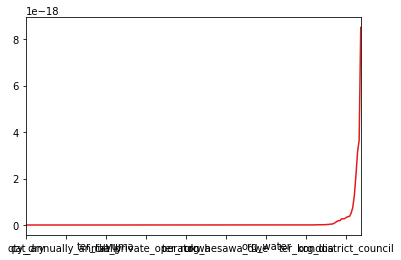

In [62]:
catfeats_score.loc[:,'pval'].plot()

In [63]:
display(xtr.shape, ff.transform(xtr,).shape,)
display(xcv.shape, ff.transform(xcv, ret_concat=True).shape,)

(41578, 56)

(41578, 210)

(8908, 56)

(8908, 258)

In [64]:
cbclf = catboost.CatBoostClassifier(1000, loss_function='MultiClass', eval_metric='Accuracy',)
cbclf.fit(ff.transform(xtr, ret_concat=True), ytr,
          eval_set=(ff.transform(xcv, ret_concat=True), ycv),
          verbose=True,)
display(cbclf.score(ff.transform(xtr, ret_concat=True), ytr),
        cbclf.score(ff.transform(xcv, ret_concat=True), ycv),
        cbclf.score(ff.transform(xva, ret_concat=True), yva)
)

Borders generated
0:	learn 0.6985184473	test 0.6971261787	bestTest 0.6971261787		total: 442ms	remaining: 7m 21s
1:	learn 0.7051084708	test 0.7073417153	bestTest 0.7073417153		total: 694ms	remaining: 5m 46s
2:	learn 0.7131175141	test 0.7144140099	bestTest 0.7144140099		total: 970ms	remaining: 5m 22s
3:	learn 0.7106642936	test 0.7107094746	bestTest 0.7144140099		total: 1.21s	remaining: 5m
4:	learn 0.7102073212	test 0.7094746295	bestTest 0.7144140099		total: 1.46s	remaining: 4m 50s
5:	learn 0.713766896	test 0.7155365963	bestTest 0.7155365963		total: 1.72s	remaining: 4m 45s
6:	learn 0.710447833	test 0.7141894926	bestTest 0.7155365963		total: 1.97s	remaining: 4m 38s
7:	learn 0.7139833566	test 0.7181185451	bestTest 0.7181185451		total: 2.22s	remaining: 4m 35s
8:	learn 0.7133099235	test 0.7155365963	bestTest 0.7181185451		total: 2.47s	remaining: 4m 32s
9:	learn 0.7121314157	test 0.7140772339	bestTest 0.7181185451		total: 2.73s	remaining: 4m 30s
10:	learn 0.714175766	test 0.7177817692	bestTest

87:	learn 0.7273798644	test 0.7314773238	bestTest 0.7314773238		total: 22s	remaining: 3m 48s
88:	learn 0.7275482226	test 0.7319263583	bestTest 0.7319263583		total: 22.3s	remaining: 3m 47s
89:	learn 0.7275482226	test 0.7314773238	bestTest 0.7319263583		total: 22.5s	remaining: 3m 47s
90:	learn 0.7273798644	test 0.7313650651	bestTest 0.7319263583		total: 22.7s	remaining: 3m 47s
91:	learn 0.7276444273	test 0.7319263583	bestTest 0.7319263583		total: 23s	remaining: 3m 46s
92:	learn 0.7280292462	test 0.7319263583	bestTest 0.7319263583		total: 23.2s	remaining: 3m 46s
93:	learn 0.7280292462	test 0.7321508756	bestTest 0.7321508756		total: 23.5s	remaining: 3m 46s
94:	learn 0.7281013998	test 0.7322631343	bestTest 0.7322631343		total: 23.8s	remaining: 3m 46s
95:	learn 0.7282938092	test 0.7324876515	bestTest 0.7324876515		total: 24s	remaining: 3m 46s
96:	learn 0.728798884	test 0.7329366861	bestTest 0.7329366861		total: 24.3s	remaining: 3m 46s
97:	learn 0.7293039588	test 0.7327121688	bestTest 0.73293

173:	learn 0.7420991871	test 0.7443870678	bestTest 0.7443870678		total: 44.8s	remaining: 3m 32s
174:	learn 0.7424118524	test 0.7446115851	bestTest 0.7446115851		total: 45s	remaining: 3m 32s
175:	learn 0.7425802107	test 0.7456219129	bestTest 0.7456219129		total: 45.2s	remaining: 3m 31s
176:	learn 0.7427726201	test 0.7455096542	bestTest 0.7456219129		total: 45.5s	remaining: 3m 31s
177:	learn 0.7426764154	test 0.7456219129	bestTest 0.7456219129		total: 45.7s	remaining: 3m 31s
178:	learn 0.7429409784	test 0.745285137	bestTest 0.7456219129		total: 46s	remaining: 3m 31s
179:	learn 0.7429409784	test 0.7453973956	bestTest 0.7456219129		total: 46.3s	remaining: 3m 30s
180:	learn 0.7432776949	test 0.7456219129	bestTest 0.7456219129		total: 46.5s	remaining: 3m 30s
181:	learn 0.7433017461	test 0.7460709475	bestTest 0.7460709475		total: 46.8s	remaining: 3m 30s
182:	learn 0.7434460532	test 0.7461832061	bestTest 0.7461832061		total: 47.1s	remaining: 3m 30s
183:	learn 0.7435903603	test 0.7464077234	bes

259:	learn 0.751262687	test 0.7511225864	bestTest 0.7514593624		total: 1m 7s	remaining: 3m 12s
260:	learn 0.7513829429	test 0.751571621	bestTest 0.751571621		total: 1m 7s	remaining: 3m 11s
261:	learn 0.7512867382	test 0.751571621	bestTest 0.751571621		total: 1m 7s	remaining: 3m 11s
262:	learn 0.7513829429	test 0.7514593624	bestTest 0.751571621		total: 1m 8s	remaining: 3m 11s
263:	learn 0.7514310453	test 0.7514593624	bestTest 0.751571621		total: 1m 8s	remaining: 3m 10s
264:	learn 0.7514310453	test 0.7516838797	bestTest 0.7516838797		total: 1m 8s	remaining: 3m 10s
265:	learn 0.7514791476	test 0.7516838797	bestTest 0.7516838797		total: 1m 9s	remaining: 3m 10s
266:	learn 0.7515513012	test 0.7516838797	bestTest 0.7516838797		total: 1m 9s	remaining: 3m 10s
267:	learn 0.7516475059	test 0.751571621	bestTest 0.7516838797		total: 1m 9s	remaining: 3m 9s
268:	learn 0.7517437106	test 0.7517961383	bestTest 0.7517961383		total: 1m 9s	remaining: 3m 9s
269:	learn 0.7516956083	test 0.7516838797	bestTest

345:	learn 0.7575400452	test 0.7579703637	bestTest 0.7583071396		total: 1m 29s	remaining: 2m 50s
346:	learn 0.7577565058	test 0.758194881	bestTest 0.7583071396		total: 1m 30s	remaining: 2m 49s
347:	learn 0.757780557	test 0.758194881	bestTest 0.7583071396		total: 1m 30s	remaining: 2m 49s
348:	learn 0.7575881476	test 0.758194881	bestTest 0.7583071396		total: 1m 30s	remaining: 2m 49s
349:	learn 0.7576362499	test 0.758194881	bestTest 0.7583071396		total: 1m 30s	remaining: 2m 48s
350:	learn 0.7579970177	test 0.7590929502	bestTest 0.7590929502		total: 1m 31s	remaining: 2m 48s
351:	learn 0.7579489153	test 0.7592052088	bestTest 0.7592052088		total: 1m 31s	remaining: 2m 48s
352:	learn 0.7578286594	test 0.7593174674	bestTest 0.7593174674		total: 1m 31s	remaining: 2m 48s
353:	learn 0.7579729665	test 0.7593174674	bestTest 0.7593174674		total: 1m 31s	remaining: 2m 47s
354:	learn 0.7580691712	test 0.7595419847	bestTest 0.7595419847		total: 1m 32s	remaining: 2m 47s
355:	learn 0.7580691712	test 0.7594

430:	learn 0.7623743326	test 0.764818141	bestTest 0.7653794342		total: 1m 51s	remaining: 2m 27s
431:	learn 0.7623743326	test 0.7651549169	bestTest 0.7653794342		total: 1m 52s	remaining: 2m 27s
432:	learn 0.7623983838	test 0.7651549169	bestTest 0.7653794342		total: 1m 52s	remaining: 2m 27s
433:	learn 0.7626869979	test 0.7654916929	bestTest 0.7654916929		total: 1m 52s	remaining: 2m 27s
434:	learn 0.7627110491	test 0.7656039515	bestTest 0.7656039515		total: 1m 53s	remaining: 2m 26s
435:	learn 0.7626388956	test 0.7656039515	bestTest 0.7656039515		total: 1m 53s	remaining: 2m 26s
436:	learn 0.7626869979	test 0.7656039515	bestTest 0.7656039515		total: 1m 53s	remaining: 2m 26s
437:	learn 0.7629034586	test 0.7660529861	bestTest 0.7660529861		total: 1m 53s	remaining: 2m 26s
438:	learn 0.7629275097	test 0.7656039515	bestTest 0.7660529861		total: 1m 54s	remaining: 2m 25s
439:	learn 0.7632401751	test 0.7658284688	bestTest 0.7660529861		total: 1m 54s	remaining: 2m 25s
440:	learn 0.7629275097	test 0.

516:	learn 0.7682909231	test 0.769533004	bestTest 0.769533004		total: 2m 14s	remaining: 2m 5s
517:	learn 0.7682909231	test 0.7694207454	bestTest 0.769533004		total: 2m 14s	remaining: 2m 5s
518:	learn 0.7683630766	test 0.76986978	bestTest 0.76986978		total: 2m 14s	remaining: 2m 5s
519:	learn 0.7683390254	test 0.7699820386	bestTest 0.7699820386		total: 2m 15s	remaining: 2m 4s
520:	learn 0.7682909231	test 0.7700942973	bestTest 0.7700942973		total: 2m 15s	remaining: 2m 4s
521:	learn 0.7683149743	test 0.7699820386	bestTest 0.7700942973		total: 2m 15s	remaining: 2m 4s
522:	learn 0.7684352302	test 0.7696452627	bestTest 0.7700942973		total: 2m 15s	remaining: 2m 3s
523:	learn 0.7683871278	test 0.7696452627	bestTest 0.7700942973		total: 2m 16s	remaining: 2m 3s
524:	learn 0.7685314349	test 0.7697575213	bestTest 0.7700942973		total: 2m 16s	remaining: 2m 3s
525:	learn 0.7685073837	test 0.7697575213	bestTest 0.7700942973		total: 2m 16s	remaining: 2m 3s
526:	learn 0.7687478955	test 0.7696452627	bestT

602:	learn 0.7723074703	test 0.7708801078	bestTest 0.7708801078		total: 2m 36s	remaining: 1m 43s
603:	learn 0.7724277262	test 0.7711046251	bestTest 0.7711046251		total: 2m 37s	remaining: 1m 42s
604:	learn 0.7724517774	test 0.7712168837	bestTest 0.7712168837		total: 2m 37s	remaining: 1m 42s
605:	learn 0.7725479821	test 0.7707678491	bestTest 0.7712168837		total: 2m 37s	remaining: 1m 42s
606:	learn 0.7724998797	test 0.7706555905	bestTest 0.7712168837		total: 2m 37s	remaining: 1m 42s
607:	learn 0.7725239309	test 0.7708801078	bestTest 0.7712168837		total: 2m 38s	remaining: 1m 41s
608:	learn 0.7725239309	test 0.7706555905	bestTest 0.7712168837		total: 2m 38s	remaining: 1m 41s
609:	learn 0.7724998797	test 0.7708801078	bestTest 0.7712168837		total: 2m 38s	remaining: 1m 41s
610:	learn 0.7727163404	test 0.7711046251	bestTest 0.7712168837		total: 2m 38s	remaining: 1m 41s
611:	learn 0.772668238	test 0.7711046251	bestTest 0.7712168837		total: 2m 39s	remaining: 1m 40s
612:	learn 0.7726201356	test 0.

687:	learn 0.7756505844	test 0.7734620566	bestTest 0.7735743152		total: 2m 58s	remaining: 1m 21s
688:	learn 0.7756505844	test 0.7734620566	bestTest 0.7735743152		total: 2m 59s	remaining: 1m 20s
689:	learn 0.7760113522	test 0.7732375393	bestTest 0.7735743152		total: 2m 59s	remaining: 1m 20s
690:	learn 0.7759391986	test 0.7731252806	bestTest 0.7735743152		total: 2m 59s	remaining: 1m 20s
691:	learn 0.7759391986	test 0.7731252806	bestTest 0.7735743152		total: 2m 59s	remaining: 1m 20s
692:	learn 0.7759632498	test 0.7733497979	bestTest 0.7735743152		total: 3m	remaining: 1m 19s
693:	learn 0.7760354033	test 0.7732375393	bestTest 0.7735743152		total: 3m	remaining: 1m 19s
694:	learn 0.7761316081	test 0.7733497979	bestTest 0.7735743152		total: 3m	remaining: 1m 19s
695:	learn 0.7761075569	test 0.7732375393	bestTest 0.7735743152		total: 3m	remaining: 1m 19s
696:	learn 0.7761797104	test 0.7733497979	bestTest 0.7735743152		total: 3m 1s	remaining: 1m 18s
697:	learn 0.7761556592	test 0.7732375393	bestT

773:	learn 0.7796190293	test 0.7766052986	bestTest 0.7766052986		total: 3m 21s	remaining: 58.8s
774:	learn 0.7798114387	test 0.7767175573	bestTest 0.7767175573		total: 3m 21s	remaining: 58.5s
775:	learn 0.7795709269	test 0.77649304	bestTest 0.7767175573		total: 3m 21s	remaining: 58.3s
776:	learn 0.7795709269	test 0.77649304	bestTest 0.7767175573		total: 3m 22s	remaining: 58s
777:	learn 0.7796430805	test 0.7763807813	bestTest 0.7767175573		total: 3m 22s	remaining: 57.7s
778:	learn 0.7797633364	test 0.7762685227	bestTest 0.7767175573		total: 3m 22s	remaining: 57.5s
779:	learn 0.7798114387	test 0.7763807813	bestTest 0.7767175573		total: 3m 22s	remaining: 57.2s
780:	learn 0.7798114387	test 0.7763807813	bestTest 0.7767175573		total: 3m 23s	remaining: 57s
781:	learn 0.7797392852	test 0.7762685227	bestTest 0.7767175573		total: 3m 23s	remaining: 56.7s
782:	learn 0.7797633364	test 0.7760440054	bestTest 0.7767175573		total: 3m 23s	remaining: 56.4s
783:	learn 0.7797873876	test 0.7762685227	bestTe

859:	learn 0.7817595844	test 0.7778401437	bestTest 0.7785136956		total: 3m 43s	remaining: 36.3s
860:	learn 0.7817355332	test 0.778064661	bestTest 0.7785136956		total: 3m 43s	remaining: 36.1s
861:	learn 0.7817355332	test 0.778064661	bestTest 0.7785136956		total: 3m 43s	remaining: 35.8s
862:	learn 0.7816393285	test 0.7779524023	bestTest 0.7785136956		total: 3m 44s	remaining: 35.6s
863:	learn 0.7816393285	test 0.7779524023	bestTest 0.7785136956		total: 3m 44s	remaining: 35.3s
864:	learn 0.7816874309	test 0.7778401437	bestTest 0.7785136956		total: 3m 44s	remaining: 35s
865:	learn 0.7816393285	test 0.7778401437	bestTest 0.7785136956		total: 3m 44s	remaining: 34.8s
866:	learn 0.7816152773	test 0.778064661	bestTest 0.7785136956		total: 3m 45s	remaining: 34.5s
867:	learn 0.7816393285	test 0.778064661	bestTest 0.7785136956		total: 3m 45s	remaining: 34.3s
868:	learn 0.781711482	test 0.7779524023	bestTest 0.7785136956		total: 3m 45s	remaining: 34s
869:	learn 0.781711482	test 0.7778401437	bestTest

945:	learn 0.7831545529	test 0.7788504715	bestTest 0.7789627301		total: 4m 5s	remaining: 14s
946:	learn 0.7832026553	test 0.7788504715	bestTest 0.7789627301		total: 4m 5s	remaining: 13.8s
947:	learn 0.7831786041	test 0.7787382128	bestTest 0.7789627301		total: 4m 6s	remaining: 13.5s
948:	learn 0.7832026553	test 0.7788504715	bestTest 0.7789627301		total: 4m 6s	remaining: 13.2s
949:	learn 0.7832026553	test 0.7788504715	bestTest 0.7789627301		total: 4m 6s	remaining: 13s
950:	learn 0.7832507576	test 0.7788504715	bestTest 0.7789627301		total: 4m 6s	remaining: 12.7s
951:	learn 0.7833710135	test 0.7790749888	bestTest 0.7790749888		total: 4m 7s	remaining: 12.5s
952:	learn 0.7834191159	test 0.7789627301	bestTest 0.7790749888		total: 4m 7s	remaining: 12.2s
953:	learn 0.7833950647	test 0.7789627301	bestTest 0.7790749888		total: 4m 7s	remaining: 11.9s
954:	learn 0.7834672182	test 0.7790749888	bestTest 0.7790749888		total: 4m 7s	remaining: 11.7s
955:	learn 0.7834912694	test 0.7790749888	bestTest 0.7

0.78452547020058683

0.77974854063762911

0.78214045321965453

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.utils

xtr2 = ff.transform(xtr, ret_concat=True)
n_inputs = xtr2.shape[1]
n_outputs = 3


Using TensorFlow backend.


In [66]:
xtr2.index

RangeIndex(start=0, stop=41578, step=1)

In [67]:
n_inputs

258

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(xtr2)
xtr2 = scaler.transform(xtr2)
xcv2 = scaler.transform(ff.transform(xcv, ret_concat=True))
xva2 = scaler.transform(ff.transform(xva, ret_concat=True))

In [116]:
clf = Sequential([
    Dropout(.1, input_shape=(n_inputs,)),
    Dense(n_inputs, activation='relu'),
    Dense(n_inputs, activation='relu'),
    Dense(n_inputs, activation='relu'),
    Dense(n_inputs, activation='relu'),
    Dense(n_inputs, activation='relu'),
    Dense(n_outputs, activation='softmax'),
])
clf.compile(optimizer='sgd',
          loss='categorical_crossentropy',
          metrics=['accuracy'])


In [117]:
clf.fit(xtr2, ybin,
      batch_size=3072,
      epochs=1500)

Epoch 1/1500
41578/41578 [==============================] - 1s - loss: 1.0313 - acc: 0.5102     
Epoch 2/1500
41578/41578 [==============================] - 1s - loss: 0.9267 - acc: 0.5484     
Epoch 3/1500
41578/41578 [==============================] - 1s - loss: 0.8980 - acc: 0.5591     
Epoch 4/1500
41578/41578 [==============================] - 1s - loss: 0.8837 - acc: 0.5714     
Epoch 5/1500
41578/41578 [==============================] - 1s - loss: 0.8733 - acc: 0.5889     
Epoch 6/1500
41578/41578 [==============================] - 1s - loss: 0.8642 - acc: 0.6029     
Epoch 7/1500
41578/41578 [==============================] - 1s - loss: 0.8553 - acc: 0.6166     
Epoch 8/1500
41578/41578 [==============================] - 1s - loss: 0.8461 - acc: 0.6299     
Epoch 9/1500
41578/41578 [==============================] - 1s - loss: 0.8375 - acc: 0.6401     
Epoch 10/1500
41578/41578 [==============================] - 1s - loss: 0.8276 - acc: 0.6505     
Epoch 11/1500
41578/41578 [==

41578/41578 [==============================] - 1s - loss: 0.6267 - acc: 0.7411     
Epoch 85/1500
41578/41578 [==============================] - 1s - loss: 0.6262 - acc: 0.7409     
Epoch 86/1500
41578/41578 [==============================] - 1s - loss: 0.6272 - acc: 0.7409     
Epoch 87/1500
41578/41578 [==============================] - 1s - loss: 0.6266 - acc: 0.7420     
Epoch 88/1500
41578/41578 [==============================] - 1s - loss: 0.6247 - acc: 0.7429     
Epoch 89/1500
41578/41578 [==============================] - 1s - loss: 0.6254 - acc: 0.7403     
Epoch 90/1500
41578/41578 [==============================] - 1s - loss: 0.6252 - acc: 0.7422     
Epoch 91/1500
41578/41578 [==============================] - 1s - loss: 0.6236 - acc: 0.7426     
Epoch 92/1500
41578/41578 [==============================] - 1s - loss: 0.6223 - acc: 0.7443     
Epoch 93/1500
41578/41578 [==============================] - 1s - loss: 0.6219 - acc: 0.7440     
Epoch 94/1500
41578/41578 [=======

41578/41578 [==============================] - 1s - loss: 0.5903 - acc: 0.7573     
Epoch 168/1500
41578/41578 [==============================] - 1s - loss: 0.5899 - acc: 0.7573     
Epoch 169/1500
41578/41578 [==============================] - 1s - loss: 0.5894 - acc: 0.7588     
Epoch 170/1500
41578/41578 [==============================] - 1s - loss: 0.5896 - acc: 0.7573     
Epoch 171/1500
41578/41578 [==============================] - 1s - loss: 0.5875 - acc: 0.7577     
Epoch 172/1500
41578/41578 [==============================] - 1s - loss: 0.5880 - acc: 0.7590     
Epoch 173/1500
41578/41578 [==============================] - 1s - loss: 0.5881 - acc: 0.7583     
Epoch 174/1500
41578/41578 [==============================] - 1s - loss: 0.5878 - acc: 0.7582     
Epoch 175/1500
41578/41578 [==============================] - 1s - loss: 0.5854 - acc: 0.7595     
Epoch 176/1500
41578/41578 [==============================] - 1s - loss: 0.5881 - acc: 0.7595     
Epoch 177/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.5661 - acc: 0.7666     
Epoch 250/1500
41578/41578 [==============================] - 1s - loss: 0.5666 - acc: 0.7669     
Epoch 251/1500
41578/41578 [==============================] - 1s - loss: 0.5648 - acc: 0.7671     
Epoch 252/1500
41578/41578 [==============================] - 1s - loss: 0.5644 - acc: 0.7682     
Epoch 253/1500
41578/41578 [==============================] - 1s - loss: 0.5625 - acc: 0.7693     
Epoch 254/1500
41578/41578 [==============================] - 1s - loss: 0.5655 - acc: 0.7674     
Epoch 255/1500
41578/41578 [==============================] - 1s - loss: 0.5645 - acc: 0.7679     
Epoch 256/1500
41578/41578 [==============================] - 1s - loss: 0.5639 - acc: 0.7676     
Epoch 257/1500
41578/41578 [==============================] - 1s - loss: 0.5638 - acc: 0.7679     
Epoch 258/1500
41578/41578 [==============================] - 1s - loss: 0.5648 - acc: 0.7683     
Epoch 259/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.5474 - acc: 0.7738     
Epoch 332/1500
41578/41578 [==============================] - 1s - loss: 0.5481 - acc: 0.7745     
Epoch 333/1500
41578/41578 [==============================] - 1s - loss: 0.5468 - acc: 0.7759     
Epoch 334/1500
41578/41578 [==============================] - 1s - loss: 0.5457 - acc: 0.7751     
Epoch 335/1500
41578/41578 [==============================] - 1s - loss: 0.5461 - acc: 0.7751     
Epoch 336/1500
41578/41578 [==============================] - 1s - loss: 0.5454 - acc: 0.7753     
Epoch 337/1500
41578/41578 [==============================] - 1s - loss: 0.5452 - acc: 0.7753     
Epoch 338/1500
41578/41578 [==============================] - 1s - loss: 0.5467 - acc: 0.7745     
Epoch 339/1500
41578/41578 [==============================] - 1s - loss: 0.5432 - acc: 0.7767     
Epoch 340/1500
41578/41578 [==============================] - 1s - loss: 0.5440 - acc: 0.7758     
Epoch 341/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.5345 - acc: 0.7784     
Epoch 414/1500
41578/41578 [==============================] - 1s - loss: 0.5307 - acc: 0.7801     
Epoch 415/1500
41578/41578 [==============================] - 1s - loss: 0.5321 - acc: 0.7794     
Epoch 416/1500
41578/41578 [==============================] - 1s - loss: 0.5321 - acc: 0.7781     
Epoch 417/1500
41578/41578 [==============================] - 1s - loss: 0.5299 - acc: 0.7800     
Epoch 418/1500
41578/41578 [==============================] - 1s - loss: 0.5317 - acc: 0.7804     
Epoch 419/1500
41578/41578 [==============================] - 1s - loss: 0.5300 - acc: 0.7807     
Epoch 420/1500
41578/41578 [==============================] - 1s - loss: 0.5296 - acc: 0.7811     
Epoch 421/1500
41578/41578 [==============================] - 1s - loss: 0.5304 - acc: 0.7817     
Epoch 422/1500
41578/41578 [==============================] - 1s - loss: 0.5315 - acc: 0.7811     
Epoch 423/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.5204 - acc: 0.7854     
Epoch 496/1500
41578/41578 [==============================] - 1s - loss: 0.5179 - acc: 0.7869     
Epoch 497/1500
41578/41578 [==============================] - 1s - loss: 0.5211 - acc: 0.7838     
Epoch 498/1500
41578/41578 [==============================] - 1s - loss: 0.5190 - acc: 0.7849     
Epoch 499/1500
41578/41578 [==============================] - 1s - loss: 0.5168 - acc: 0.7863     
Epoch 500/1500
41578/41578 [==============================] - 1s - loss: 0.5169 - acc: 0.7865     
Epoch 501/1500
41578/41578 [==============================] - 1s - loss: 0.5164 - acc: 0.7858     
Epoch 502/1500
41578/41578 [==============================] - 1s - loss: 0.5190 - acc: 0.7862     
Epoch 503/1500
41578/41578 [==============================] - 1s - loss: 0.5182 - acc: 0.7858     
Epoch 504/1500
41578/41578 [==============================] - 1s - loss: 0.5163 - acc: 0.7857     
Epoch 505/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.5069 - acc: 0.7888     
Epoch 578/1500
41578/41578 [==============================] - 1s - loss: 0.5060 - acc: 0.7913     
Epoch 579/1500
41578/41578 [==============================] - 1s - loss: 0.5061 - acc: 0.7893     
Epoch 580/1500
41578/41578 [==============================] - 1s - loss: 0.5066 - acc: 0.7915     
Epoch 581/1500
41578/41578 [==============================] - 1s - loss: 0.5081 - acc: 0.7882     
Epoch 582/1500
41578/41578 [==============================] - 1s - loss: 0.5058 - acc: 0.7934     
Epoch 583/1500
41578/41578 [==============================] - 1s - loss: 0.5046 - acc: 0.7915     
Epoch 584/1500
41578/41578 [==============================] - 1s - loss: 0.5051 - acc: 0.7912     
Epoch 585/1500
41578/41578 [==============================] - 1s - loss: 0.5034 - acc: 0.7921     
Epoch 586/1500
41578/41578 [==============================] - 1s - loss: 0.5108 - acc: 0.7890     
Epoch 587/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.5013 - acc: 0.7933     
Epoch 660/1500
41578/41578 [==============================] - 1s - loss: 0.4987 - acc: 0.7931     
Epoch 661/1500
41578/41578 [==============================] - 1s - loss: 0.4960 - acc: 0.7953     
Epoch 662/1500
41578/41578 [==============================] - 1s - loss: 0.4966 - acc: 0.7942     
Epoch 663/1500
41578/41578 [==============================] - 1s - loss: 0.4957 - acc: 0.7962     
Epoch 664/1500
41578/41578 [==============================] - 1s - loss: 0.4945 - acc: 0.7950     
Epoch 665/1500
41578/41578 [==============================] - 1s - loss: 0.4976 - acc: 0.7932     
Epoch 666/1500
41578/41578 [==============================] - 1s - loss: 0.4953 - acc: 0.7957     
Epoch 667/1500
41578/41578 [==============================] - 1s - loss: 0.4929 - acc: 0.7970     
Epoch 668/1500
41578/41578 [==============================] - 1s - loss: 0.4977 - acc: 0.7950     
Epoch 669/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.4868 - acc: 0.7994     
Epoch 742/1500
41578/41578 [==============================] - 1s - loss: 0.4868 - acc: 0.7989     
Epoch 743/1500
41578/41578 [==============================] - 1s - loss: 0.4863 - acc: 0.7996     
Epoch 744/1500
41578/41578 [==============================] - 1s - loss: 0.4895 - acc: 0.7962     
Epoch 745/1500
41578/41578 [==============================] - 1s - loss: 0.4853 - acc: 0.7987     
Epoch 746/1500
41578/41578 [==============================] - 1s - loss: 0.4874 - acc: 0.7978     
Epoch 747/1500
41578/41578 [==============================] - 1s - loss: 0.4909 - acc: 0.7964     
Epoch 748/1500
41578/41578 [==============================] - 1s - loss: 0.4864 - acc: 0.7993     
Epoch 749/1500
41578/41578 [==============================] - 1s - loss: 0.4865 - acc: 0.7984     
Epoch 750/1500
41578/41578 [==============================] - 1s - loss: 0.4897 - acc: 0.7977     
Epoch 751/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.4798 - acc: 0.8006     
Epoch 824/1500
41578/41578 [==============================] - 1s - loss: 0.4953 - acc: 0.7936     
Epoch 825/1500
41578/41578 [==============================] - 1s - loss: 0.4837 - acc: 0.7979     
Epoch 826/1500
41578/41578 [==============================] - 1s - loss: 0.4768 - acc: 0.8034     
Epoch 827/1500
41578/41578 [==============================] - 1s - loss: 0.4788 - acc: 0.8025     
Epoch 828/1500
41578/41578 [==============================] - 1s - loss: 0.4878 - acc: 0.7970     
Epoch 829/1500
41578/41578 [==============================] - 1s - loss: 0.4779 - acc: 0.8008     
Epoch 830/1500
41578/41578 [==============================] - 1s - loss: 0.4808 - acc: 0.8012     
Epoch 831/1500
41578/41578 [==============================] - 1s - loss: 0.4797 - acc: 0.8016     
Epoch 832/1500
41578/41578 [==============================] - 1s - loss: 0.4846 - acc: 0.7994     
Epoch 833/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.4760 - acc: 0.8023     
Epoch 906/1500
41578/41578 [==============================] - 1s - loss: 0.4741 - acc: 0.8034     
Epoch 907/1500
41578/41578 [==============================] - 1s - loss: 0.4729 - acc: 0.8045     
Epoch 908/1500
41578/41578 [==============================] - 1s - loss: 0.4683 - acc: 0.8061     
Epoch 909/1500
41578/41578 [==============================] - 1s - loss: 0.4719 - acc: 0.8058     
Epoch 910/1500
41578/41578 [==============================] - 1s - loss: 0.4787 - acc: 0.7997     
Epoch 911/1500
41578/41578 [==============================] - 1s - loss: 0.4714 - acc: 0.8036     
Epoch 912/1500
41578/41578 [==============================] - 1s - loss: 0.4796 - acc: 0.8004     
Epoch 913/1500
41578/41578 [==============================] - 1s - loss: 0.4831 - acc: 0.7994     
Epoch 914/1500
41578/41578 [==============================] - 1s - loss: 0.4745 - acc: 0.8029     
Epoch 915/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.4772 - acc: 0.8009     
Epoch 988/1500
41578/41578 [==============================] - 1s - loss: 0.4645 - acc: 0.8082     
Epoch 989/1500
41578/41578 [==============================] - 1s - loss: 0.4653 - acc: 0.8048     
Epoch 990/1500
41578/41578 [==============================] - 1s - loss: 0.4612 - acc: 0.8099     
Epoch 991/1500
41578/41578 [==============================] - 1s - loss: 0.4660 - acc: 0.8072     
Epoch 992/1500
41578/41578 [==============================] - 1s - loss: 0.4611 - acc: 0.8094     
Epoch 993/1500
41578/41578 [==============================] - 1s - loss: 0.4641 - acc: 0.8064     
Epoch 994/1500
41578/41578 [==============================] - 1s - loss: 0.4609 - acc: 0.8093     
Epoch 995/1500
41578/41578 [==============================] - 1s - loss: 0.4824 - acc: 0.8000     
Epoch 996/1500
41578/41578 [==============================] - 1s - loss: 0.4631 - acc: 0.8093     
Epoch 997/1500
41578/4157

41578/41578 [==============================] - 1s - loss: 0.4563 - acc: 0.8115     
Epoch 1070/1500
41578/41578 [==============================] - 1s - loss: 0.4602 - acc: 0.8075     
Epoch 1071/1500
41578/41578 [==============================] - 1s - loss: 0.4550 - acc: 0.8135     
Epoch 1072/1500
41578/41578 [==============================] - 1s - loss: 0.4666 - acc: 0.8057     
Epoch 1073/1500
41578/41578 [==============================] - 1s - loss: 0.4544 - acc: 0.8124     
Epoch 1074/1500
41578/41578 [==============================] - 1s - loss: 0.4716 - acc: 0.8038     
Epoch 1075/1500
41578/41578 [==============================] - 1s - loss: 0.4576 - acc: 0.8097     
Epoch 1076/1500
41578/41578 [==============================] - 1s - loss: 0.4581 - acc: 0.8100     
Epoch 1077/1500
41578/41578 [==============================] - 1s - loss: 0.4544 - acc: 0.8112     
Epoch 1078/1500
41578/41578 [==============================] - 1s - loss: 0.4507 - acc: 0.8153     
Epoch 1079/1500


41578/41578 [==============================] - 1s - loss: 0.4604 - acc: 0.8086     
Epoch 1152/1500
41578/41578 [==============================] - 1s - loss: 0.4540 - acc: 0.8097     
Epoch 1153/1500
41578/41578 [==============================] - 1s - loss: 0.4509 - acc: 0.8144     
Epoch 1154/1500
41578/41578 [==============================] - 1s - loss: 0.4475 - acc: 0.8156     
Epoch 1155/1500
41578/41578 [==============================] - 1s - loss: 0.4512 - acc: 0.8129     
Epoch 1156/1500
41578/41578 [==============================] - 1s - loss: 0.4545 - acc: 0.8134     
Epoch 1157/1500
41578/41578 [==============================] - 1s - loss: 0.4517 - acc: 0.8146     
Epoch 1158/1500
41578/41578 [==============================] - 1s - loss: 0.4619 - acc: 0.8070     
Epoch 1159/1500
41578/41578 [==============================] - 1s - loss: 0.4625 - acc: 0.8080     
Epoch 1160/1500
41578/41578 [==============================] - 1s - loss: 0.4513 - acc: 0.8142     
Epoch 1161/1500


41578/41578 [==============================] - 1s - loss: 0.4553 - acc: 0.8115     
Epoch 1234/1500
41578/41578 [==============================] - 1s - loss: 0.4540 - acc: 0.8089     
Epoch 1235/1500
41578/41578 [==============================] - 1s - loss: 0.4449 - acc: 0.8171     
Epoch 1236/1500
41578/41578 [==============================] - 1s - loss: 0.4428 - acc: 0.8166     
Epoch 1237/1500
41578/41578 [==============================] - 1s - loss: 0.4524 - acc: 0.8120     
Epoch 1238/1500
41578/41578 [==============================] - 1s - loss: 0.4404 - acc: 0.8176     
Epoch 1239/1500
41578/41578 [==============================] - 1s - loss: 0.4413 - acc: 0.8188     
Epoch 1240/1500
41578/41578 [==============================] - 1s - loss: 0.4504 - acc: 0.8131     
Epoch 1241/1500
41578/41578 [==============================] - 1s - loss: 0.4755 - acc: 0.8016     
Epoch 1242/1500
41578/41578 [==============================] - 1s - loss: 0.4466 - acc: 0.8155     
Epoch 1243/1500


41578/41578 [==============================] - 1s - loss: 0.4403 - acc: 0.8159     
Epoch 1316/1500
41578/41578 [==============================] - 1s - loss: 0.4418 - acc: 0.8156     
Epoch 1317/1500
41578/41578 [==============================] - 1s - loss: 0.4362 - acc: 0.8189     
Epoch 1318/1500
41578/41578 [==============================] - 1s - loss: 0.4359 - acc: 0.8209     
Epoch 1319/1500
41578/41578 [==============================] - 1s - loss: 0.4387 - acc: 0.8190     
Epoch 1320/1500
41578/41578 [==============================] - 1s - loss: 0.4388 - acc: 0.8191     
Epoch 1321/1500
41578/41578 [==============================] - 1s - loss: 0.4435 - acc: 0.8161     
Epoch 1322/1500
41578/41578 [==============================] - 1s - loss: 0.4376 - acc: 0.8193     
Epoch 1323/1500
41578/41578 [==============================] - 1s - loss: 0.4362 - acc: 0.8193     
Epoch 1324/1500
41578/41578 [==============================] - 1s - loss: 0.4394 - acc: 0.8176     
Epoch 1325/1500


41578/41578 [==============================] - 1s - loss: 0.4325 - acc: 0.8215     
Epoch 1398/1500
41578/41578 [==============================] - 1s - loss: 0.4380 - acc: 0.8185     
Epoch 1399/1500
41578/41578 [==============================] - 1s - loss: 0.4350 - acc: 0.8188     
Epoch 1400/1500
41578/41578 [==============================] - 1s - loss: 0.4566 - acc: 0.8089     
Epoch 1401/1500
41578/41578 [==============================] - 1s - loss: 0.4360 - acc: 0.8200     
Epoch 1402/1500
41578/41578 [==============================] - 1s - loss: 0.4338 - acc: 0.8219     
Epoch 1403/1500
41578/41578 [==============================] - 1s - loss: 0.4315 - acc: 0.8214     
Epoch 1404/1500
41578/41578 [==============================] - 1s - loss: 0.4306 - acc: 0.8210     
Epoch 1405/1500
41578/41578 [==============================] - 1s - loss: 0.4378 - acc: 0.8190     
Epoch 1406/1500
41578/41578 [==============================] - 1s - loss: 0.4476 - acc: 0.8137     
Epoch 1407/1500


41578/41578 [==============================] - 1s - loss: 0.4280 - acc: 0.8227     
Epoch 1480/1500
41578/41578 [==============================] - 1s - loss: 0.4613 - acc: 0.8069     
Epoch 1481/1500
41578/41578 [==============================] - 1s - loss: 0.4330 - acc: 0.8199     
Epoch 1482/1500
41578/41578 [==============================] - 1s - loss: 0.4310 - acc: 0.8212     
Epoch 1483/1500
41578/41578 [==============================] - 1s - loss: 0.4360 - acc: 0.8201     
Epoch 1484/1500
41578/41578 [==============================] - 1s - loss: 0.4263 - acc: 0.8233     
Epoch 1485/1500
41578/41578 [==============================] - 1s - loss: 0.4276 - acc: 0.8229     
Epoch 1486/1500
41578/41578 [==============================] - 1s - loss: 0.4261 - acc: 0.8230     
Epoch 1487/1500
41578/41578 [==============================] - 1s - loss: 0.4261 - acc: 0.8225     
Epoch 1488/1500
41578/41578 [==============================] - 1s - loss: 0.4293 - acc: 0.8218     
Epoch 1489/1500


In [118]:
#for i in range(48):
#    clf.train_on_batch(xtr2, ybin)

In [119]:
display(
    clf.evaluate(xtr2, ybinarizer.transform(ytr)),
    clf.evaluate(xcv2, ybinarizer.transform(ycv)),
    clf.evaluate(xva2, ybinarizer.transform(yva)),)

8192/8914 [==========================>...] - ETA: 0s

[0.37509563837487653, 0.85117129251332935]

[0.54142575136577809, 0.78468792099667928]

[0.54000287012372394, 0.78494503027605911]